# Experiment 1: K-Means on Original Data
This notebook replicates `Exp1.py`: run K-Means on the breast cancer dataset, compare kmeans++ vs random init, pick k via elbow, silhouette, and gap statistic, and report internal/external metrics plus confusion matrices.

In [62]:
# Setup and Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from Kmeans import KMeans
import part3

# Plot style
sns.set(style="whitegrid")

In [63]:
# Load and Standardize Dataset
X_raw, y_true = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X_raw)
print(f"Data shape: {X.shape}, positive class ratio: {y_true.mean():.3f}")

Data shape: (569, 30), positive class ratio: 0.627


In [64]:
# Helper: Within-Cluster Sum of Squares

def _within_cluster_ss(X, labels, centroids):
    ss = 0.0
    for i in range(centroids.shape[0]):
        pts = X[labels == i]
        if pts.size == 0:
            continue
        diff = pts - centroids[i]
        ss += np.sum(diff * diff)
    return ss

In [65]:
# Helper: Gap Statistic and Optimal k Selection

def gap_statistic(X, k_max=10, B=10, init="kmeans++", max_iter=300, tol=1e-4, random_state=42):
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape
    mins = X.min(axis=0)
    maxs = X.max(axis=0)

    Wks = np.zeros(k_max)
    Wkbs = np.zeros((k_max, B))

    for k in range(1, k_max + 1):
        km = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        km.fit(X)
        Wks[k - 1] = _within_cluster_ss(X, km.labels_, km.centroids_)

        for b in range(B):
            Xb = rng.uniform(mins, maxs, size=(n_samples, n_features))
            km_b = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
            np.random.seed(int(rng.integers(0, 2**32 - 1)))
            km_b.fit(Xb)
            Wkbs[k - 1, b] = _within_cluster_ss(Xb, km_b.labels_, km_b.centroids_)

    logWks = np.log(Wks)
    logWkbs = np.log(Wkbs)
    gaps = np.mean(logWkbs, axis=1) - logWks
    sk = np.sqrt(1 + 1.0 / B) * np.std(logWkbs, axis=1)
    return gaps, sk


def select_gap_k(gaps, sk):
    k_vals = np.arange(1, len(gaps) + 1)
    for i in range(len(gaps) - 1):
        if gaps[i] >= gaps[i + 1] - sk[i + 1]:
            return k_vals[i]
    return k_vals[-1]

In [66]:
# Run KMeans Across k Values

def run_kmeans_series(X, y_true, k_values, init_method, tol=1e-4, max_iter=300, random_state=42):
    rng = np.random.default_rng(random_state)
    records = {
        "inertia": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "wcss": [],
        "ari": [],
        "nmi": [],
        "purity": [],
        "time": [],
        "iterations": [],
        "labels": []
    }

    for k in k_values:
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        km = KMeans(k=k, init=init_method, max_iter=max_iter, tol=tol)
        start = time.time()
        km.fit(X)
        elapsed = time.time() - start
        labels = km.labels_

        records["inertia"].append(km.inertia_)
        records["time"].append(elapsed)
        records["iterations"].append(km.iterations_)

        if k > 1:
            sil, _ = part3.silhouette_score(X, labels)
            dbi = part3.davies_bouldin_index(X, labels)
            chi = part3.calinski_harabasz_index(X, labels)
        else:
            sil, dbi, chi = np.nan, np.nan, np.nan

        records["silhouette"].append(sil)
        records["davies_bouldin"].append(dbi)
        records["calinski_harabasz"].append(chi)
        records["wcss"].append(part3.within_cluster_sum_of_squares(X, labels))
        records["labels"].append(labels)

        records["ari"].append(part3.adjusted_rand_index(y_true, labels))
        records["nmi"].append(part3.normalized_mutual_information(y_true, labels))
        records["purity"].append(part3.purity_score(y_true, labels))

    return records

In [67]:
# Elbow and Silhouette Heuristics

def pick_elbow_k(k_values, inertia_values):
    inertia_arr = np.array(inertia_values)
    if len(inertia_arr) < 3:
        return k_values[len(k_values) // 2]
    second = np.diff(inertia_arr, n=2)
    idx = np.argmax(second) + 1
    return k_values[idx]


def best_silhouette_k(k_values, silhouette_values):
    return k_values[int(np.nanargmax(silhouette_values))]

In [68]:
# Plot Internal Metrics and Convergence

def plot_metric_curves(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["inertia"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow (Inertia)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["silhouette"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Silhouette")
    plt.title("Silhouette Analysis")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_internal_metrics(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["davies_bouldin"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Davies-Bouldin (lower better)")
    plt.title("Davies-Bouldin vs k")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["calinski_harabasz"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Calinski-Harabasz (higher better)")
    plt.title("Calinski-Harabasz vs k")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_convergence(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["iterations"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Iterations")
    plt.title("Convergence speed (iterations)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["time"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Time (s)")
    plt.title("Convergence speed (time)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [69]:
# Compute and Plot Gap Statistic

def plot_gap(k_values, gaps, sk, optimal_k):
    plt.figure(figsize=(8, 5))
    plt.errorbar(k_values, gaps, yerr=sk, fmt="o-", capsize=5, label="Gap")
    plt.axvline(optimal_k, color="r", linestyle="--", label=f"Optimal k={optimal_k}")
    plt.xlabel("k")
    plt.ylabel("Gap statistic")
    plt.title("Gap Statistic")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_gap_and_plot(X, max_k, init="kmeans++", B=10):
    gaps, sk = gap_statistic(X, k_max=max_k, init=init, B=B, random_state=42)
    gap_k = select_gap_k(gaps, sk)
    plot_gap(np.arange(1, len(gaps) + 1), gaps, sk, gap_k)
    print(f"Gap statistic optimal k={gap_k}")
    return gaps, sk, gap_k

In [70]:
# External Metrics at k=2 with Confusion Matrix

def plot_confusion(cm, true_classes, pred_clusters, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {c}" for c in pred_clusters],
        yticklabels=[f"True {c}" for c in true_classes],
    )
    plt.title(title)
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Classes")
    plt.tight_layout()
    plt.show()


def report_k2_confusion(results, k_values, y_true):
    k_report = 2
    if k_report not in k_values:
        print("k=2 not in k_values; skipping confusion matrices.")
        return
    idx = k_values.index(k_report)
    for init_method, res in results.items():
        print(
            f"Init={init_method}, k={k_report}: "
            f"ARI={res['ari'][idx]:.3f}, NMI={res['nmi'][idx]:.3f}, Purity={res['purity'][idx]:.3f}, "
            f"WCSS={res['wcss'][idx]:.1f}, Silhouette={res['silhouette'][idx]:.3f}"
        )
        cm, true_classes, pred_clusters = part3.confusion_matrix(y_true, res["labels"][idx])
        title = f"Confusion Matrix (init={init_method}, k={k_report})"
        plot_confusion(cm, true_classes, pred_clusters, title)

Init=kmeans++: elbow k=3, silhouette-opt k=2
Init=random: elbow k=3, silhouette-opt k=2


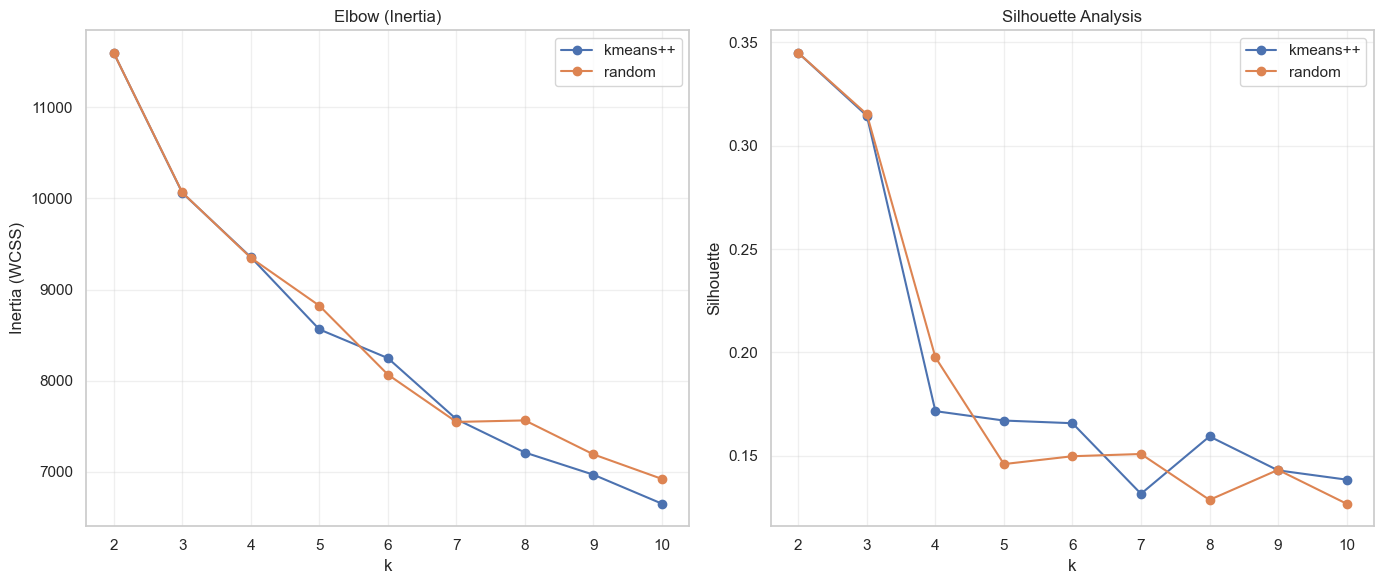

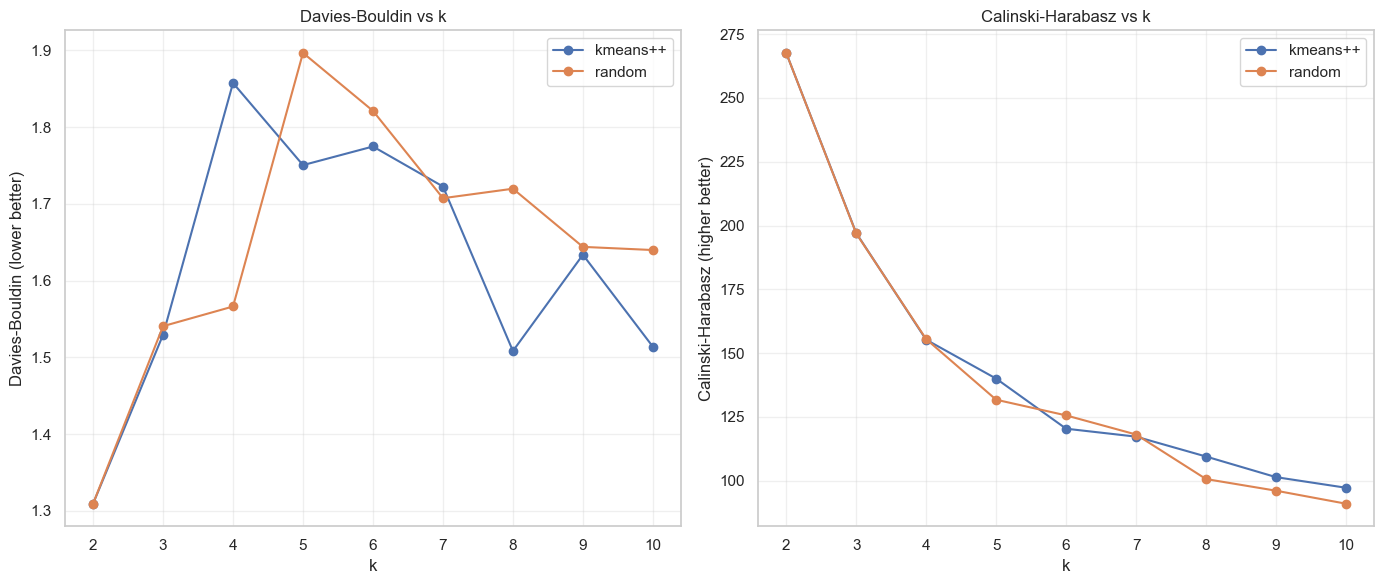

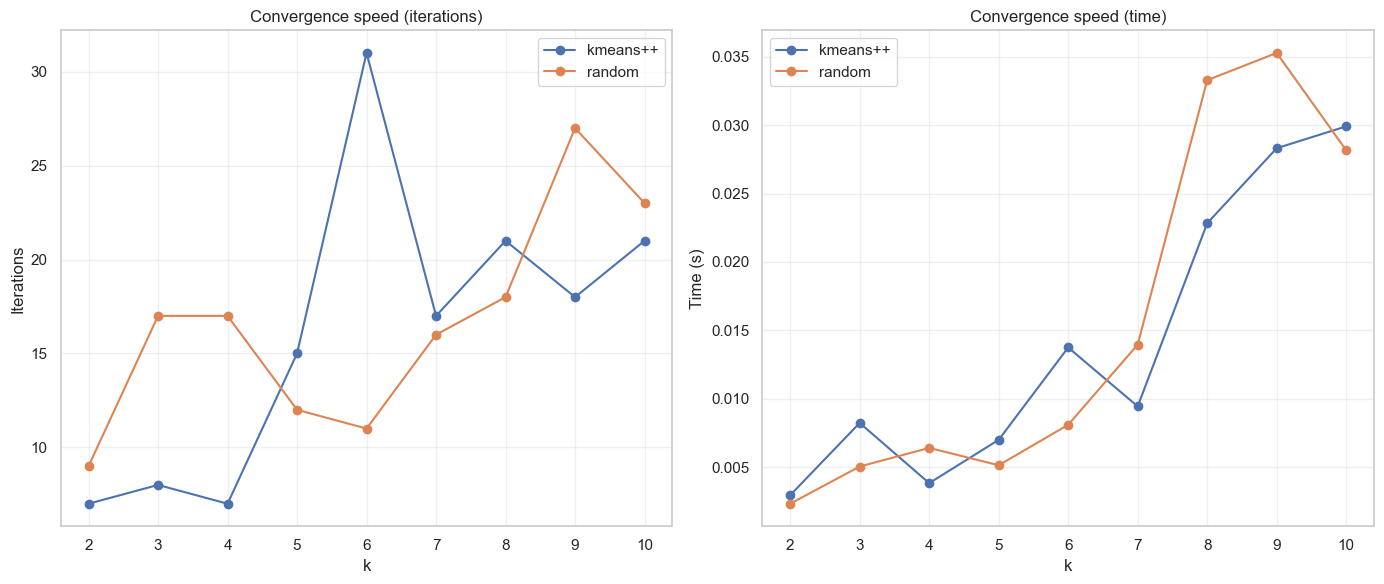

Computing gap statistic (kmeans++ init)...


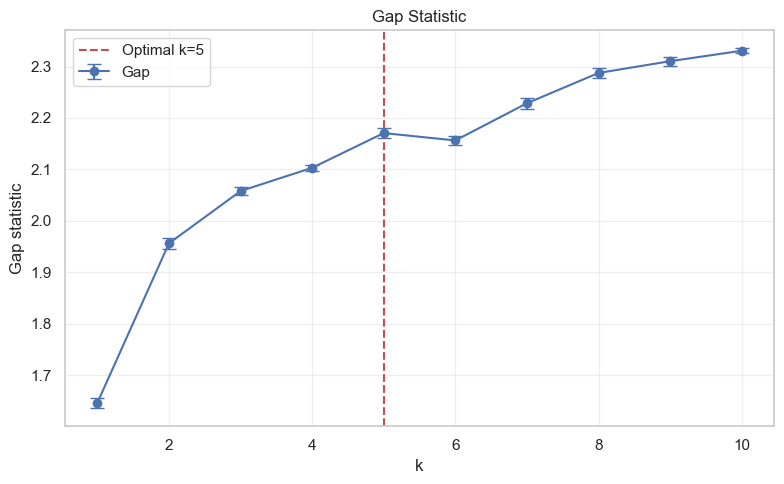

Gap statistic optimal k=5
Init=kmeans++, k=2: ARI=0.677, NMI=0.562, Purity=0.912, WCSS=11595.7, Silhouette=0.345


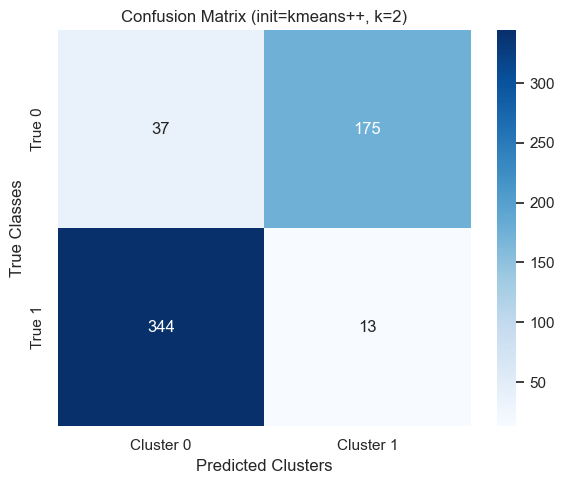

Init=random, k=2: ARI=0.677, NMI=0.562, Purity=0.912, WCSS=11595.7, Silhouette=0.345


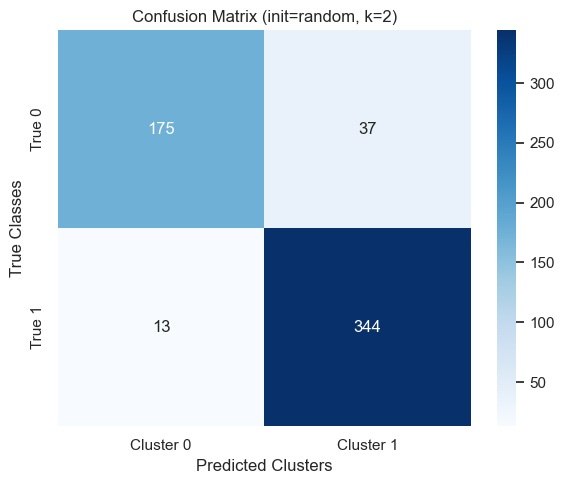

In [71]:
# Run the experiment end-to-end
k_values = list(range(2, 11))

results = {}
for init_method in ["kmeans++", "random"]:
    res = run_kmeans_series(X, y_true, k_values, init_method)
    results[init_method] = res
    elbow_k = pick_elbow_k(k_values, res["inertia"])
    best_sil_k = best_silhouette_k(k_values, res["silhouette"])
    print(f"Init={init_method}: elbow k={elbow_k}, silhouette-opt k={best_sil_k}")

    # Best-by-metric (from part3.py): max for all except WCSS and DBI (min)
    idx_ari_exp1 = int(np.nanargmax(res["ari"]))
    best_ari_k_exp1 = k_values[idx_ari_exp1]
    best_ari_value_exp1 = res["ari"][idx_ari_exp1]

    idx_nmi_exp1 = int(np.nanargmax(res["nmi"]))
    best_nmi_k_exp1 = k_values[idx_nmi_exp1]
    best_nmi_value_exp1 = res["nmi"][idx_nmi_exp1]

    idx_purity_exp1 = int(np.nanargmax(res["purity"]))
    best_purity_k_exp1 = k_values[idx_purity_exp1]
    best_purity_value_exp1 = res["purity"][idx_purity_exp1]

    idx_sil_exp1 = int(np.nanargmax(res["silhouette"]))
    best_sil_k_exp1 = k_values[idx_sil_exp1]
    best_sil_value_exp1 = res["silhouette"][idx_sil_exp1]

    idx_ch_exp1 = int(np.nanargmax(res["calinski_harabasz"]))
    best_ch_k_exp1 = k_values[idx_ch_exp1]
    best_ch_value_exp1 = res["calinski_harabasz"][idx_ch_exp1]

    idx_wcss_exp1 = int(np.nanargmin(res["wcss"]))
    best_wcss_k_exp1 = k_values[idx_wcss_exp1]
    best_wcss_value_exp1 = res["wcss"][idx_wcss_exp1]

    idx_dbi_exp1 = int(np.nanargmin(res["davies_bouldin"]))
    best_dbi_k_exp1 = k_values[idx_dbi_exp1]
    best_dbi_value_exp1 = res["davies_bouldin"][idx_dbi_exp1]

plot_metric_curves(k_values, results)
plot_internal_metrics(k_values, results)
plot_convergence(k_values, results)

print("Computing gap statistic (kmeans++ init)...")
gaps, sk, gap_k = compute_gap_and_plot(X, max_k=max(k_values), init="kmeans++", B=10)

report_k2_confusion(results, k_values, y_true)

In [72]:
# Setup and Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from Kmeans import KMeans
import part3

# Plot style
sns.set(style="whitegrid")

In [73]:
# Load and Standardize Dataset
X_raw, y_true = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X_raw)
print(f"Data shape: {X.shape}, positive class ratio: {y_true.mean():.3f}")

Data shape: (569, 30), positive class ratio: 0.627


In [74]:
# Helper: Within-Cluster Sum of Squares

def _within_cluster_ss(X, labels, centroids):
    ss = 0.0
    for i in range(centroids.shape[0]):
        pts = X[labels == i]
        if pts.size == 0:
            continue
        diff = pts - centroids[i]
        ss += np.sum(diff * diff)
    return ss

In [75]:
# Helper: Gap Statistic and Optimal k Selection

def gap_statistic(X, k_max=10, B=10, init="kmeans++", max_iter=300, tol=1e-4, random_state=42):
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape
    mins = X.min(axis=0)
    maxs = X.max(axis=0)

    Wks = np.zeros(k_max)
    Wkbs = np.zeros((k_max, B))

    for k in range(1, k_max + 1):
        km = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        km.fit(X)
        Wks[k - 1] = _within_cluster_ss(X, km.labels_, km.centroids_)

        for b in range(B):
            Xb = rng.uniform(mins, maxs, size=(n_samples, n_features))
            km_b = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
            np.random.seed(int(rng.integers(0, 2**32 - 1)))
            km_b.fit(Xb)
            Wkbs[k - 1, b] = _within_cluster_ss(Xb, km_b.labels_, km_b.centroids_)

    logWks = np.log(Wks)
    logWkbs = np.log(Wkbs)
    gaps = np.mean(logWkbs, axis=1) - logWks
    sk = np.sqrt(1 + 1.0 / B) * np.std(logWkbs, axis=1)
    return gaps, sk


def select_gap_k(gaps, sk):
    k_vals = np.arange(1, len(gaps) + 1)
    for i in range(len(gaps) - 1):
        if gaps[i] >= gaps[i + 1] - sk[i + 1]:
            return k_vals[i]
    return k_vals[-1]

In [76]:
# Run KMeans Across k Values

def run_kmeans_series(X, y_true, k_values, init_method, tol=1e-4, max_iter=300, random_state=42):
    rng = np.random.default_rng(random_state)
    records = {
        "inertia": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "wcss": [],
        "ari": [],
        "nmi": [],
        "purity": [],
        "time": [],
        "iterations": [],
        "labels": []
    }

    for k in k_values:
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        km = KMeans(k=k, init=init_method, max_iter=max_iter, tol=tol)
        start = time.time()
        km.fit(X)
        elapsed = time.time() - start
        labels = km.labels_

        records["inertia"].append(km.inertia_)
        records["time"].append(elapsed)
        records["iterations"].append(km.iterations_)

        if k > 1:
            sil, _ = part3.silhouette_score(X, labels)
            dbi = part3.davies_bouldin_index(X, labels)
            chi = part3.calinski_harabasz_index(X, labels)
        else:
            sil, dbi, chi = np.nan, np.nan, np.nan

        records["silhouette"].append(sil)
        records["davies_bouldin"].append(dbi)
        records["calinski_harabasz"].append(chi)
        records["wcss"].append(part3.within_cluster_sum_of_squares(X, labels))
        records["labels"].append(labels)

        records["ari"].append(part3.adjusted_rand_index(y_true, labels))
        records["nmi"].append(part3.normalized_mutual_information(y_true, labels))
        records["purity"].append(part3.purity_score(y_true, labels))

    return records

In [77]:
# Elbow and Silhouette Heuristics

def pick_elbow_k(k_values, inertia_values):
    inertia_arr = np.array(inertia_values)
    if len(inertia_arr) < 3:
        return k_values[len(k_values) // 2]
    second = np.diff(inertia_arr, n=2)
    idx = np.argmax(second) + 1
    return k_values[idx]


def best_silhouette_k(k_values, silhouette_values):
    return k_values[int(np.nanargmax(silhouette_values))]

In [78]:
# Plot Internal Metrics and Convergence

def plot_metric_curves(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["inertia"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow (Inertia)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["silhouette"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Silhouette")
    plt.title("Silhouette Analysis")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_internal_metrics(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["davies_bouldin"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Davies-Bouldin (lower better)")
    plt.title("Davies-Bouldin vs k")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["calinski_harabasz"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Calinski-Harabasz (higher better)")
    plt.title("Calinski-Harabasz vs k")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_convergence(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["iterations"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Iterations")
    plt.title("Convergence speed (iterations)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["time"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Time (s)")
    plt.title("Convergence speed (time)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [79]:
# Compute and Plot Gap Statistic

def plot_gap(k_values, gaps, sk, optimal_k):
    plt.figure(figsize=(8, 5))
    plt.errorbar(k_values, gaps, yerr=sk, fmt="o-", capsize=5, label="Gap")
    plt.axvline(optimal_k, color="r", linestyle="--", label=f"Optimal k={optimal_k}")
    plt.xlabel("k")
    plt.ylabel("Gap statistic")
    plt.title("Gap Statistic")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_gap_and_plot(X, max_k, init="kmeans++", B=10):
    gaps, sk = gap_statistic(X, k_max=max_k, init=init, B=B, random_state=42)
    gap_k = select_gap_k(gaps, sk)
    plot_gap(np.arange(1, len(gaps) + 1), gaps, sk, gap_k)
    print(f"Gap statistic optimal k={gap_k}")
    return gaps, sk, gap_k

In [80]:
# External Metrics at k=2 with Confusion Matrix

def plot_confusion(cm, true_classes, pred_clusters, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {c}" for c in pred_clusters],
        yticklabels=[f"True {c}" for c in true_classes],
    )
    plt.title(title)
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Classes")
    plt.tight_layout()
    plt.show()


def report_k2_confusion(results, k_values, y_true):
    k_report = 2
    if k_report not in k_values:
        print("k=2 not in k_values; skipping confusion matrices.")
        return
    idx = k_values.index(k_report)
    for init_method, res in results.items():
        print(
            f"Init={init_method}, k={k_report}: "
            f"ARI={res['ari'][idx]:.3f}, NMI={res['nmi'][idx]:.3f}, Purity={res['purity'][idx]:.3f}, "
            f"WCSS={res['wcss'][idx]:.1f}, Silhouette={res['silhouette'][idx]:.3f}"
        )
        cm, true_classes, pred_clusters = part3.confusion_matrix(y_true, res["labels"][idx])
        title = f"Confusion Matrix (init={init_method}, k={k_report})"
        plot_confusion(cm, true_classes, pred_clusters, title)

Init=kmeans++: elbow k=3, silhouette-opt k=2
Init=random: elbow k=3, silhouette-opt k=2


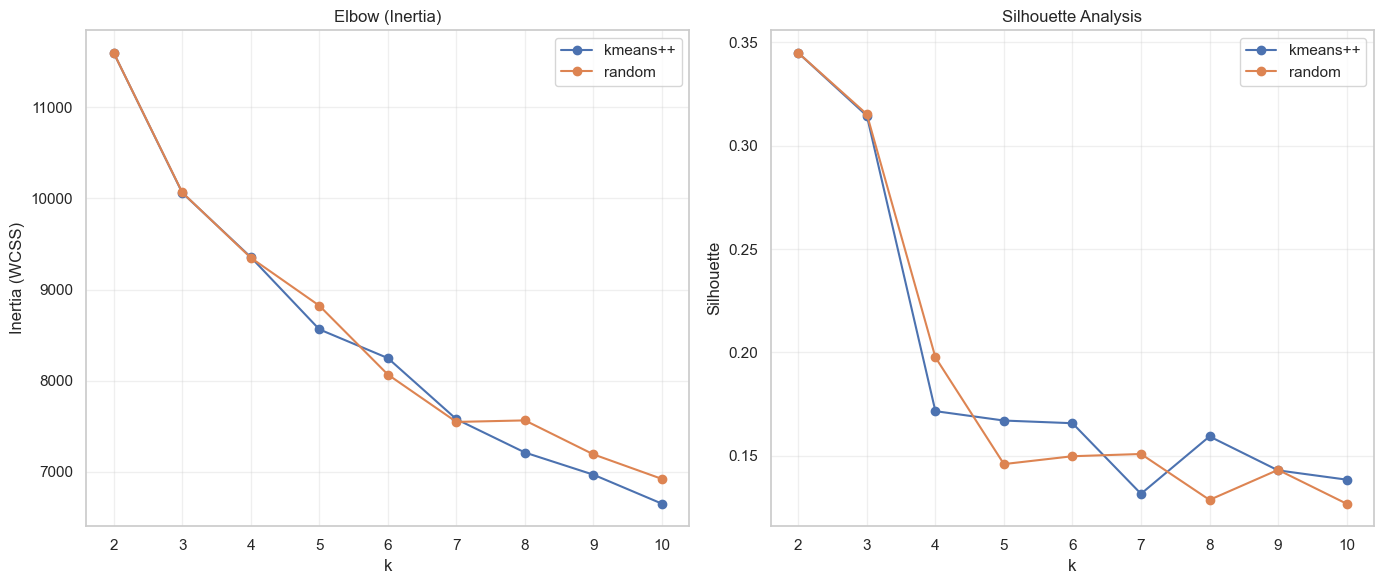

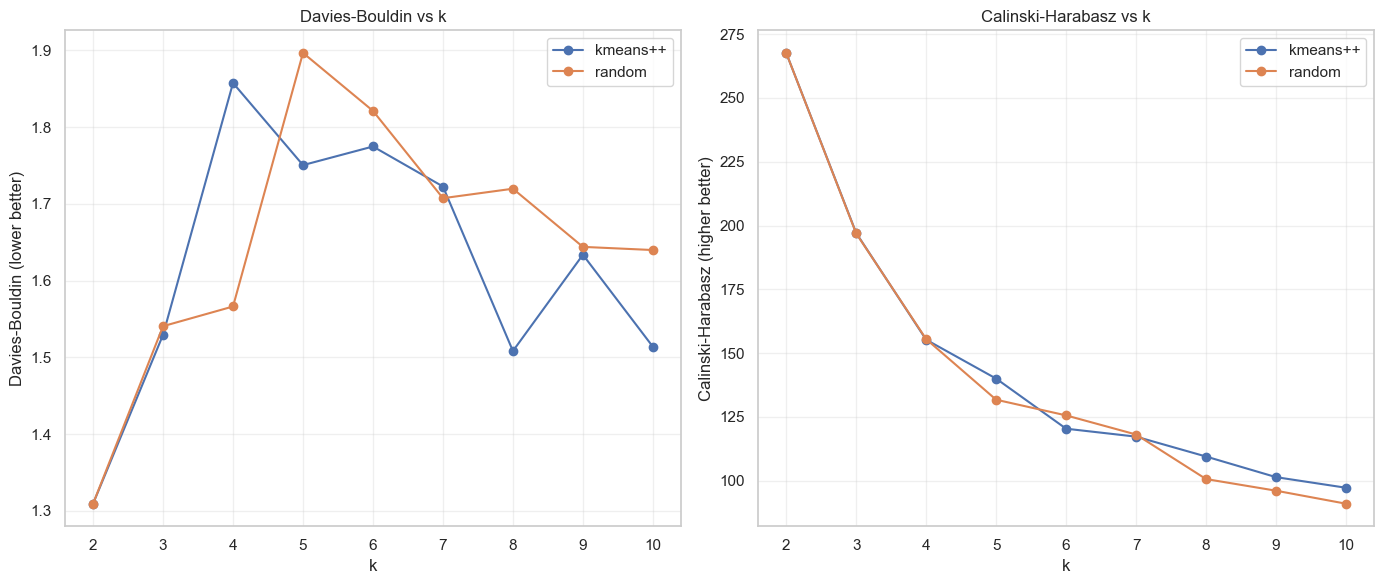

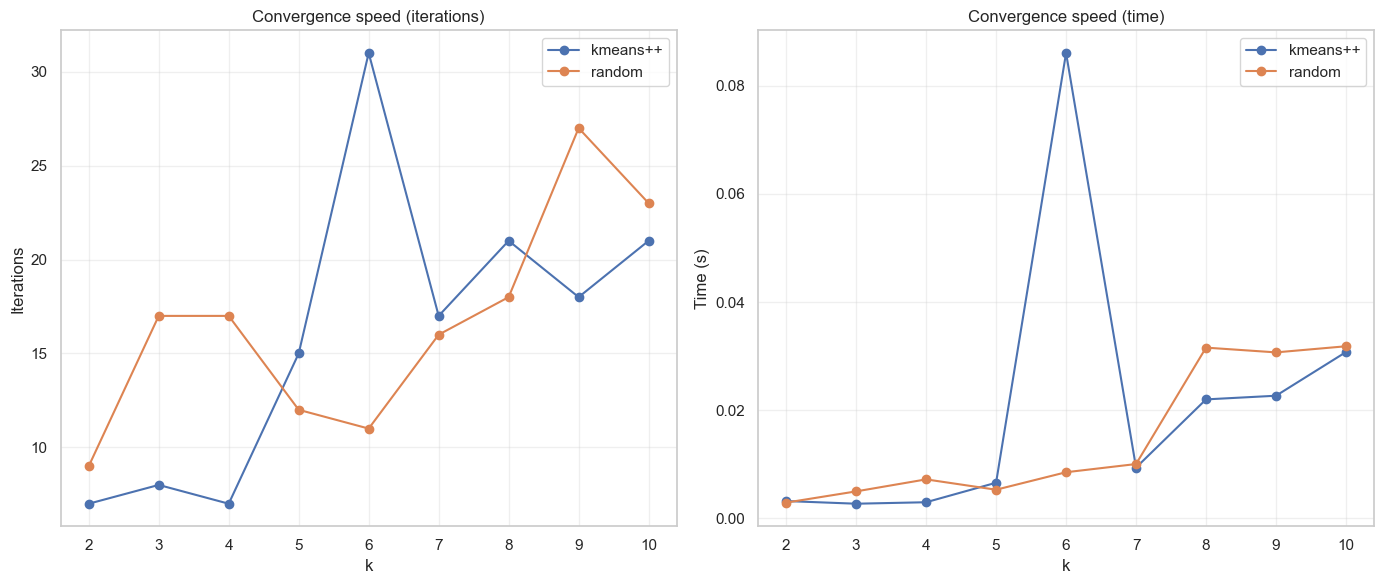

Computing gap statistic (kmeans++ init)...


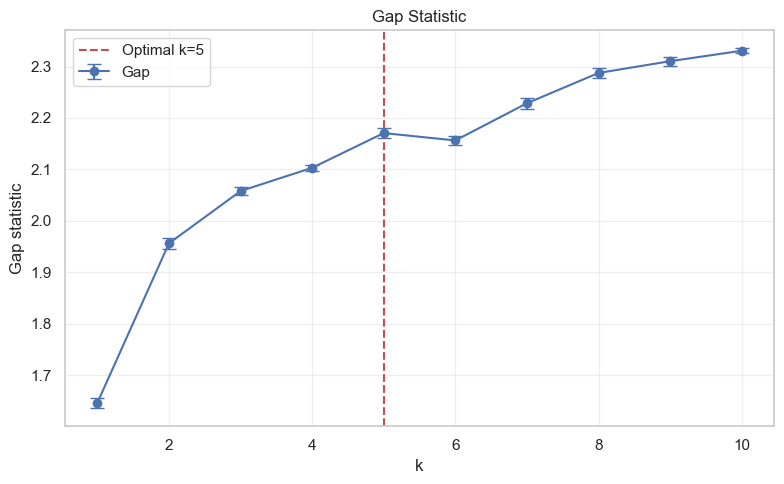

Gap statistic optimal k=5
Init=kmeans++, k=2: ARI=0.677, NMI=0.562, Purity=0.912, WCSS=11595.7, Silhouette=0.345


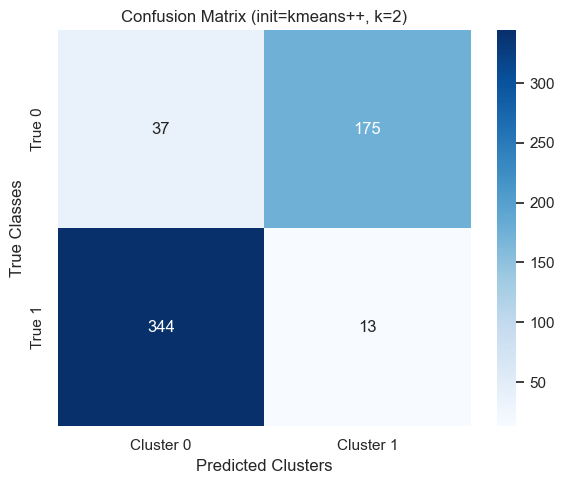

Init=random, k=2: ARI=0.677, NMI=0.562, Purity=0.912, WCSS=11595.7, Silhouette=0.345


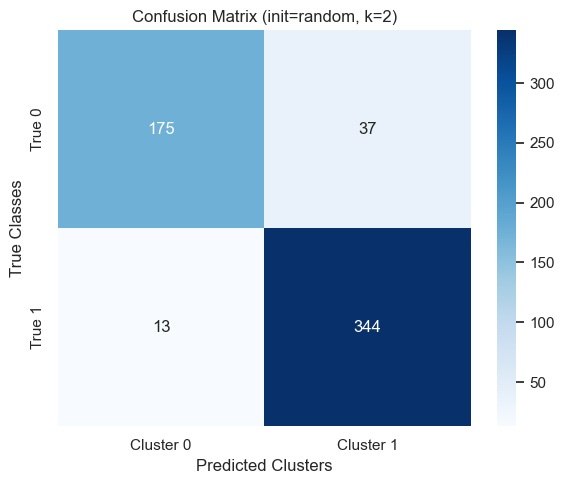

In [81]:
# Run the experiment end-to-end
k_values = list(range(2, 11))

results = {}
for init_method in ["kmeans++", "random"]:
    res = run_kmeans_series(X, y_true, k_values, init_method)
    results[init_method] = res
    elbow_k = pick_elbow_k(k_values, res["inertia"])
    best_sil_k = best_silhouette_k(k_values, res["silhouette"])
    print(f"Init={init_method}: elbow k={elbow_k}, silhouette-opt k={best_sil_k}")

plot_metric_curves(k_values, results)
plot_internal_metrics(k_values, results)
plot_convergence(k_values, results)

print("Computing gap statistic (kmeans++ init)...")
gaps, sk, gap_k = compute_gap_and_plot(X, max_k=max(k_values), init="kmeans++", B=10)

report_k2_confusion(results, k_values, y_true)

# Experiment 2: GMM

## Load csv file

In [82]:
import pandas as pd
import numpy as np
import part3 as eval

def load_data(file_path, random_state=None):
    data = pd.read_csv(file_path)
    y = data['diagnosis'].values
    # Convert to numeric if string labels (e.g., 'M', 'B' -> 0, 1)
    if y.dtype == 'object':
        unique_labels = np.unique(y)
        label_map = {label: i for i, label in enumerate(unique_labels)}
        y = np.array([label_map[label] for label in y])
    
    # Remove non-feature columns
    columns_to_drop = []
    if 'id' in data.columns:
        columns_to_drop.append('id')
    if 'diagnosis' in data.columns:
        columns_to_drop.append('diagnosis')
    
    if columns_to_drop:
        data = data.drop(columns=columns_to_drop)
    
    # Store feature names
    feature_names = list(data.columns)
    
    # Fill missing values with column-wise mean
    data = data.fillna(data.mean())
    
    # Convert to NumPy arrays
    X = data.values.astype(float)
    
    # Compute mean and std
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1.0  # prevent division by zero
    
    # Standardize
    X = (X - mean) / std
    
    # Store preprocessing parameters
    preprocessing_params = {
        'mean': mean,
        'std': std,
        'feature_names': feature_names
    }
    
    print(f"Loaded data: {X.shape[0]} samples, {X.shape[1]} features")
    if y is not None:
        print(f"Target classes: {np.unique(y)} (counts: {np.bincount(y)})")
    
    return X, y, feature_names, preprocessing_params

In [83]:
def initialize_parameters(X, n_components, covariance_type='full', random_state=None):
    """
    Initialize GMM parameters using k-means++ style initialization.
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        Training data
    n_components : int
        Number of Gaussian components
    covariance_type : str
        Type of covariance: 'full', 'tied', 'diagonal', 'spherical'
    random_state : int or None
        Random seed for reproducibility
        
    Returns:
    --------
    means : array, shape (n_components, n_features)
    covariances : array or float
        Shape depends on covariance_type
    weights : array, shape (n_components,)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples, n_features = X.shape
    
    # Initialize means using k-means++ style
    means = np.zeros((n_components, n_features))
    
    # First center: random sample
    means[0] = X[np.random.randint(n_samples)]
    
    for k in range(1, n_components):
        # Compute distances to nearest center
        distances = np.min([np.sum((X - means[j])**2, axis=1) 
                           for j in range(k)], axis=0)
        
        # Add small epsilon to avoid numerical issues
        distances = np.maximum(distances, 1e-10)
        
        # Compute probabilities
        distance_sum = distances.sum()
        
        # Check for edge cases
        if distance_sum < 1e-10:
            # All points are very close to existing centers
            # Choose a random point
            means[k] = X[np.random.randint(n_samples)]
        else:
            probs = distances / distance_sum
            
            # Additional safety check: ensure probs sum to 1 and contain no NaN
            if np.any(np.isnan(probs)) or np.abs(probs.sum() - 1.0) > 1e-6:
                # Fallback to uniform random selection
                means[k] = X[np.random.randint(n_samples)]
            else:
                # Normalize to ensure exact sum to 1
                probs = probs / probs.sum()
                means[k] = X[np.random.choice(n_samples, p=probs)]
    
    # Initialize covariances
    covariances = initialize_covariances(X, n_components, covariance_type)
    
    # Initialize weights uniformly
    weights = np.ones(n_components) / n_components
    
    return means, covariances, weights

def initialize_covariances(X, n_components, covariance_type):
    """
    Initialize covariance matrices based on type.
    """
    n_features = X.shape[1]
    
    # Compute overall covariance of data
    data_cov = np.cov(X.T) + 1e-6 * np.eye(n_features)
    
    if covariance_type == 'full':
        # Each component has its own full covariance matrix
        covariances = np.array([data_cov for _ in range(n_components)])
        
    elif covariance_type == 'tied':
        # All components share the same covariance matrix
        covariances = data_cov
        
    elif covariance_type == 'diagonal':
        # Each component has diagonal covariance
        diag_cov = np.diag(np.diag(data_cov))
        covariances = np.array([diag_cov for _ in range(n_components)])
        
    elif covariance_type == 'spherical':
        # Each component has spherical covariance (scalar * I)
        variance = np.mean(np.diag(data_cov))
        covariances = np.array([variance for _ in range(n_components)])
    
    return covariances

In [84]:
# GAUSSIAN PROBABILITY DENSITY FUNCTION
def compute_gaussian_pdf(X, mean, covariance, covariance_type):
    """
    Compute Gaussian probability density function.
    """
    n_samples, n_features = X.shape
    diff = X - mean
    
    if covariance_type == 'full' or covariance_type == 'tied':
        # Full or tied covariance matrix
        cov_inv = np.linalg.inv(covariance)
        det = np.linalg.det(covariance)
        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det)
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        return norm_const * np.exp(exponent)
            
    elif covariance_type == 'diagonal':
        # Diagonal covariance
        cov_diag = np.diag(covariance)
        det = np.prod(cov_diag)
        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det)
        exponent = -0.5 * np.sum((diff**2) / cov_diag, axis=1)
        return norm_const * np.exp(exponent)
        
    elif covariance_type == 'spherical':
        # Spherical covariance (scalar variance)
        variance = covariance
        det = variance**n_features
        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det)
        exponent = -0.5 * np.sum(diff**2, axis=1) / variance
        return norm_const * np.exp(exponent)

In [85]:
# E-STEP: EXPECTATION
def e_step(X, means, covariances, weights, covariance_type):
    """
    E-step: Compute responsibilities (posterior probabilities).
    """
    n_samples = X.shape[0]
    n_components = len(means)
    
    # Compute weighted probabilities for each component
    weighted_prob = np.zeros((n_samples, n_components))
    
    for k in range(n_components):
        if covariance_type == 'tied':
            cov = covariances
        elif covariance_type in ['full', 'diagonal', 'spherical']:
            cov = covariances[k]
        # Compute probability density
        prob = compute_gaussian_pdf(X, means[k], cov, covariance_type)
        weighted_prob[:, k] = weights[k] * prob
    
    # Compute total probability (sum over components)
    total_prob = np.sum(weighted_prob, axis=1, keepdims=True)
    
    # Add small constant for numerical stability
    total_prob = np.maximum(total_prob, 1e-300)
    
    # Compute responsibilities (normalize)
    responsibilities = weighted_prob / total_prob
    
    # Compute log-likelihood
    log_likelihood = np.sum(np.log(total_prob.flatten()))
    
    return responsibilities, log_likelihood

In [86]:
# M-STEP: MAXIMIZATION
def m_step(X, responsibilities, covariance_type, reg_covar=1e-6):
    """
    M-step: Update parameters to maximize expected log-likelihood.
    reg_covar : float
        Regularization added to diagonal for numerical stability
    """
    n_samples, n_features = X.shape
    n_components = responsibilities.shape[1]
    
    # Compute effective number of samples per component
    Nk = np.sum(responsibilities, axis=0)
    
    # Update weights
    weights = Nk / n_samples
    
    # Update means
    means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
    
    # Update covariances based on type
    covariances = update_covariances(X, responsibilities, means, Nk, 
                                    covariance_type, reg_covar)
    
    return means, covariances, weights


def update_covariances(X, responsibilities, means, Nk, covariance_type, reg_covar):
    """
    Update covariance matrices based on type.
    Nk : array, shape (n_components,)
        Effective number of samples per component
    """
    n_samples, n_features = X.shape
    n_components = len(means)
    
    if covariance_type == 'full':
        # Full covariance for each component
        covariances = np.zeros((n_components, n_features, n_features))
        for k in range(n_components):
            diff = X - means[k]
            weighted_diff = responsibilities[:, k:k+1] * diff
            covariances[k] = np.dot(weighted_diff.T, diff) / Nk[k]
            # Add regularization for numerical stability
            covariances[k] += reg_covar * np.eye(n_features)
            
    elif covariance_type == 'tied':
        # Single shared covariance matrix
        covariances = np.zeros((n_features, n_features))
        for k in range(n_components):
            diff = X - means[k]
            weighted_diff = responsibilities[:, k:k+1] * diff
            covariances += np.dot(weighted_diff.T, diff)
        covariances /= n_samples
        covariances += reg_covar * np.eye(n_features)
        
    elif covariance_type == 'diagonal':
        # Diagonal covariance for each component
        covariances = np.zeros((n_components, n_features, n_features))
        for k in range(n_components):
            diff = X - means[k]
            weighted_sq_diff = responsibilities[:, k:k+1] * (diff**2)
            variance = np.sum(weighted_sq_diff, axis=0) / Nk[k]
            covariances[k] = np.diag(variance + reg_covar)
            
    elif covariance_type == 'spherical':
        # Spherical covariance for each component (scalar variance)
        covariances = np.zeros(n_components)
        for k in range(n_components):
            diff = X - means[k]
            weighted_sq_diff = responsibilities[:, k:k+1] * (diff**2)
            covariances[k] = np.sum(weighted_sq_diff) / (Nk[k] * n_features)
            covariances[k] += reg_covar
    
    return covariances

In [87]:
# CONVERGENCE MONITORING
def check_convergence(log_likelihood_history, tol=1e-3, n_iter=10):
    """
    Check if EM algorithm has converged.
    """
    if len(log_likelihood_history) < n_iter:
        return False
    
    # Check relative change in log-likelihood
    current_ll = log_likelihood_history[-1]
    previous_ll = log_likelihood_history[-2]
    
    # Avoid division by zero
    if abs(previous_ll) < 1e-10:
        change = abs(current_ll - previous_ll)
    else:
        change = abs((current_ll - previous_ll) / previous_ll)
    
    return change < tol

In [88]:
# MAIN EM ALGORITHM
def fit_gmm(X, n_components, covariance_type='full', max_iter=100, 
            tol=1e-3, reg_covar=1e-6, random_state=None, verbose=False):
    # Initialize parameters
    means, covariances, weights = initialize_parameters(
        X, n_components, covariance_type, random_state
    )
    
    log_likelihood_history = []
    
    for iteration in range(max_iter):
        # E-step: Compute responsibilities
        responsibilities, log_likelihood = e_step(
            X, means, covariances, weights, covariance_type
        )
        
        log_likelihood_history.append(log_likelihood)
        
        if verbose:
            print(f"Iteration {iteration + 1}: Log-likelihood = {log_likelihood:.4f}")
        
        # Check convergence
        if iteration > 0 and check_convergence(log_likelihood_history, tol):
            if verbose:
                print(f"Converged at iteration {iteration + 1}")
            converged = True
            break
        
        # M-step: Update parameters
        means, covariances, weights = m_step(
            X, responsibilities, covariance_type, reg_covar
        )
        
        converged = False
    
    return {
        'means': means,
        'covariances': covariances,
        'weights': weights,
        'log_likelihood': log_likelihood_history[-1],
        'log_likelihood_history': log_likelihood_history,
        'converged': converged,
        'n_iter': len(log_likelihood_history)
    }

In [89]:
def predict_proba(X, means, covariances, weights, covariance_type):
    responsibilities, _ = e_step(X, means, covariances, weights, covariance_type)
    return responsibilities


def predict(X, means, covariances, weights, covariance_type):
    probabilities = predict_proba(X, means, covariances, weights, covariance_type)
    return np.argmax(probabilities, axis=1)

# Experiment 2: GMM on original data

## Find optimal components using BIC and AIC

In [90]:

def compute_bic_aic(X, n_components, log_likelihood, covariance_type):
    """
    Compute BIC and AIC for GMM.
    
    BIC = -2 * log(L) + k * log(n)
    AIC = -2 * log(L) + 2k
    
    where:
    - log(L) = log-likelihood
    - k = number of parameters
    - n = number of samples
    
    Lower BIC/AIC indicates better model.
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
    n_components : int
    log_likelihood : float
    covariance_type : str
    
    Returns:
    --------
    bic : float
    aic : float
    """
    n_samples, n_features = X.shape
    
    # Count parameters based on covariance type
    # Means: K * d
    # Weights: K - 1 (sum to 1)
    n_params = n_components * n_features + (n_components - 1)
    
    # Covariances:
    if covariance_type == 'full':
        # K * d * (d + 1) / 2
        n_params += n_components * n_features * (n_features + 1) // 2
    elif covariance_type == 'tied':
        # d * (d + 1) / 2
        n_params += n_features * (n_features + 1) // 2
    elif covariance_type == 'diagonal':
        # K * d
        n_params += n_components * n_features
    elif covariance_type == 'spherical':
        # K
        n_params += n_components
    
    bic = -2 * log_likelihood + n_params * np.log(n_samples)
    aic = -2 * log_likelihood + 2 * n_params
    
    return bic, aic


In [91]:
from matplotlib import pyplot as plt
def plot_bic_aic_curves(k_values, bic_scores, aic_scores, save_path=None):
    """
    Plot BIC and AIC curves for GMM.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, bic_scores, 'bo-', label='BIC', linewidth=2, markersize=8)
    plt.plot(k_values, aic_scores, 'rs-', label='AIC', linewidth=2, markersize=8)
    
    optimal_k_bic = k_values[np.argmin(bic_scores)]
    optimal_k_aic = k_values[np.argmin(aic_scores)]
    
    plt.axvline(x=optimal_k_bic, color='b', linestyle='--', alpha=0.5)
    plt.axvline(x=optimal_k_aic, color='r', linestyle='--', alpha=0.5)
    
    plt.xlabel('Number of Components (k)', fontsize=12)
    plt.ylabel('Information Criterion', fontsize=12)
    plt.title('GMM Model Selection - BIC & AIC', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

In [92]:
def confusion_matrix(true_labels, pred_labels):
    true_unique = np.unique(true_labels)
    pred_unique = np.unique(pred_labels)
    
    cm = np.zeros((len(true_unique), len(pred_unique)), dtype=int)
    
    for i, t in enumerate(true_unique):
        for j, p in enumerate(pred_unique):
            cm[i, j] = np.sum((true_labels == t) & (pred_labels == p))
    
    return cm, true_unique, pred_unique

def cluster_composition(true_labels, cluster_labels):
    clusters = np.unique(cluster_labels)
    classes = np.unique(true_labels)
    
    composition = {}
    
    for cluster in clusters:
        indices = np.where(cluster_labels == cluster)[0]
        class_counts = {cls: np.sum(true_labels[indices] == cls) for cls in classes}
        composition[cluster] = class_counts
        
    return composition

def unsupervised_confusion_matrix(true_labels, cluster_labels):
    clusters = np.unique(cluster_labels)
    classes = np.unique(true_labels)
    cm = np.zeros((len(classes), len(clusters)), dtype=int)
    
    for i, cls in enumerate(classes):
        for j, cluster in enumerate(clusters):
            cm[i, j] = np.sum((true_labels == cls) & (cluster_labels == cluster))
    
    return cm

In [93]:

def plot_2d_projection(X_2d, labels, title='2D Projection', true_labels=None, 
                       centers=None, save_path=None):
    """
    Plot 2D projection of data with cluster assignments.
    
    Parameters:
    -----------
    X_2d : array, shape (n_samples, 2)
    labels : array, shape (n_samples,)
        Predicted cluster labels
    title : str
    true_labels : array or None
        True labels for comparison
    centers : array or None, shape (n_clusters, 2)
        Cluster centers
    save_path : str or None
    """
    fig, axes = plt.subplots(1, 2 if true_labels is not None else 1, 
                             figsize=(15 if true_labels is not None else 8, 6))
    
    if true_labels is None:
        axes = [axes]
    
    # Plot predicted labels
    scatter = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels, 
                             cmap='tab10', alpha=0.6, s=30)
    if centers is not None:
        axes[0].scatter(centers[:, 0], centers[:, 1], c='red', 
                       marker='X', s=200, edgecolors='black', linewidths=2,
                       label='Centers')
        axes[0].legend()
    
    axes[0].set_title(f'{title} - Predicted Clusters')
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')
    plt.colorbar(scatter, ax=axes[0])
    
    # Plot true labels if available
    if true_labels is not None:
        scatter = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=true_labels,
                                 cmap='tab10', alpha=0.6, s=30)
        axes[1].set_title(f'{title} - True Labels')
        axes[1].set_xlabel('Component 1')
        axes[1].set_ylabel('Component 2')
        plt.colorbar(scatter, ax=axes[1])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()



Loaded data: 569 samples, 30 features
Target classes: [0 1] (counts: [357 212])


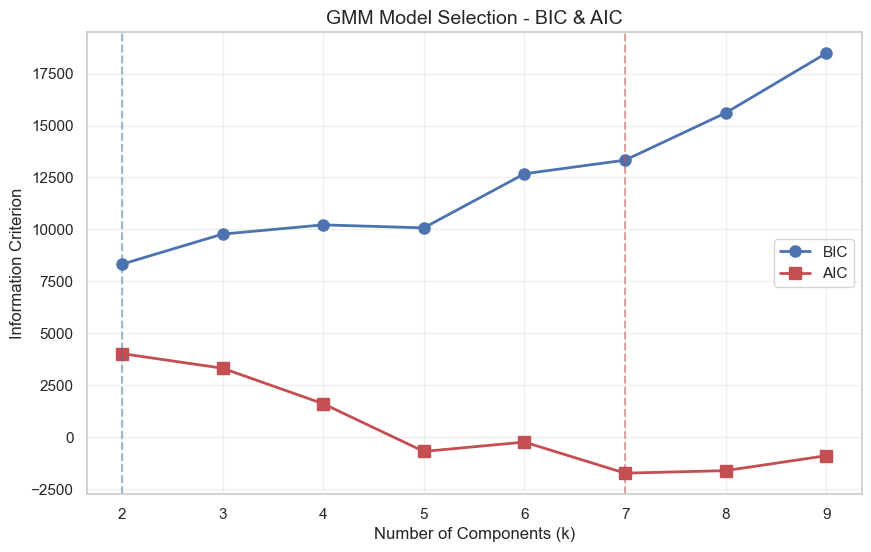

In [94]:
X, y, _, _ = load_data('data.csv', random_state=42)
bic_scores_gmm, aic_scores_gmm = [], []
k_values_gmm = range(2, 10)
mapped_labels_arr_gmm = []
for k in k_values_gmm:
    model = fit_gmm(X, n_components=k, covariance_type='full', max_iter=100, 
            tol=1e-3, reg_covar=1e-6, random_state=42, verbose=False)
    bic, aic = compute_bic_aic(X, k, model['log_likelihood'], 'full')
    bic_scores_gmm.append(bic)
    aic_scores_gmm.append(aic)
    pred_labels = predict(X, model['means'], model['covariances'], 
                      model['weights'], 'full')
    cm = unsupervised_confusion_matrix(y, pred_labels)
    mapped_labels_arr_gmm.append(cm)
plot_bic_aic_curves(k_values_gmm, bic_scores_gmm, aic_scores_gmm)

In [95]:
for k, mapped_labels_gmm in zip(k_values_gmm, mapped_labels_arr_gmm):
    print(f"\nGMM with k={k}:")
    # confusion_matrix
    print(mapped_labels_gmm)


GMM with k=2:
[[255 102]
 [115  97]]

GMM with k=3:
[[312  34  11]
 [ 73 111  28]]

GMM with k=4:
[[237   3   4 113]
 [ 77  45  22  68]]

GMM with k=5:
[[206   2   3  32 114]
 [ 82  31  17  50  32]]

GMM with k=6:
[[206   2   3  32 114   0]
 [ 82  31  16  50  32   1]]

GMM with k=7:
[[226   2   2  34  87   0   6]
 [ 15  29  13  36  36   1  82]]

GMM with k=8:
[[232   2   2  31  81   0   9   0]
 [ 14  29  13  35  27   1  92   1]]

GMM with k=9:
[[237   2   2  51  55   0   9   0   1]
 [ 11  28  13  33  47   1  78   1   0]]


In [96]:
covariance_types_gmm = ['full', 'tied', 'diagonal', 'spherical']
best_k_gmm = k_values_gmm[np.argmin(bic_scores_gmm)]
covariance_types_scores = {}
mapped_labels_arr_gmm = []
for cov_type in covariance_types_gmm:
    model = fit_gmm(X, n_components=best_k_gmm, covariance_type=cov_type, max_iter=100, 
            tol=1e-3, reg_covar=1e-6, random_state=42, verbose=True)
    covariance_types_scores[cov_type] = model
    print("\nResults for covariance type:", cov_type)
    print(f"Covariance Type: {cov_type}")
    print(f"Converged: {model['converged']} in {model['n_iter']} iterations")
    print(f"Final Log-Likelihood: {model['log_likelihood']:.4f}\n")
    pred_labels = predict(X, model['means'], model['covariances'], 
                          model['weights'], cov_type)
    cm = unsupervised_confusion_matrix(y, pred_labels)
    mapped_labels_arr_gmm.append(cm)
best_cov_type_gmm = min(covariance_types_scores, 
                    key=lambda ct: compute_bic_aic(
                        X, best_k_gmm, 
                        covariance_types_scores[ct]['log_likelihood'], 
                        ct)[0])
print("best model covariance type:",  best_cov_type_gmm)

Iteration 1: Log-likelihood = -8082.6510
Iteration 2: Log-likelihood = -3033.7732
Iteration 3: Log-likelihood = -2367.7488
Iteration 4: Log-likelihood = -2072.7958
Iteration 5: Log-likelihood = -1843.7935
Iteration 6: Log-likelihood = -1731.2613
Iteration 7: Log-likelihood = -1521.1198
Iteration 8: Log-likelihood = -1415.4457
Iteration 9: Log-likelihood = -1381.1044
Iteration 10: Log-likelihood = -1340.9947
Iteration 11: Log-likelihood = -1233.6382
Iteration 12: Log-likelihood = -1182.7309
Iteration 13: Log-likelihood = -1135.6366
Iteration 14: Log-likelihood = -1103.9436
Iteration 15: Log-likelihood = -1083.0452
Iteration 16: Log-likelihood = -1068.8769
Iteration 17: Log-likelihood = -1063.2828
Iteration 18: Log-likelihood = -1058.1536
Iteration 19: Log-likelihood = -1051.1053
Iteration 20: Log-likelihood = -1047.4947
Iteration 21: Log-likelihood = -1045.3456
Iteration 22: Log-likelihood = -1040.0957
Iteration 23: Log-likelihood = -1034.1916
Iteration 24: Log-likelihood = -1026.8217
I

In [97]:
for cov_type, mapped_labels_gmm in zip(covariance_types_gmm, mapped_labels_arr_gmm):
    print(f"\nGMM with covariance type={cov_type}:")
    print(mapped_labels_gmm)


GMM with covariance type=full:
[[255 102]
 [115  97]]

GMM with covariance type=tied:
[[355   2]
 [137  75]]

GMM with covariance type=diagonal:
[[326  31]
 [ 19 193]]

GMM with covariance type=spherical:
[[314  43]
 [ 30 182]]


In [98]:
print("confusion matrix for the best model:")
best_model_gmm = covariance_types_scores[best_cov_type_gmm]
pred_labels_gmm = predict(X, best_model_gmm['means'], best_model_gmm['covariances'], 
                      best_model_gmm['weights'], best_cov_type_gmm)
print("best model info:")
print("covariance_type:", best_cov_type_gmm)
print("best number of components:", best_k_gmm)
print(f"Converged: {best_model_gmm['converged']} in {best_model_gmm['n_iter']} iterations")
print(f"Final Log-Likelihood: {best_model_gmm['log_likelihood']:.4f}\n")
cm_gmm = unsupervised_confusion_matrix(y, pred_labels_gmm)
print(cm_gmm)

confusion matrix for the best model:
best model info:
covariance_type: full
best number of components: 2
Converged: True in 27 iterations
Final Log-Likelihood: -1017.3322

[[255 102]
 [115  97]]


### Adjusted Rand Index , Normalized Mutual Information, Purity

In [99]:
ari_gmm = eval.adjusted_rand_index(y, pred_labels_gmm)
nmi_gmm = eval.normalized_mutual_information(y, pred_labels_gmm)
purity_gmm = eval.purity_score(y, pred_labels_gmm)

silhouette_gmm, _ = eval.silhouette_score(X, pred_labels_gmm)
db_gmm = eval.davies_bouldin_index(X, pred_labels_gmm)
ch_gmm = eval.calinski_harabasz_index(X, pred_labels_gmm)
wcss_gmm = eval.within_cluster_sum_of_squares(X, pred_labels_gmm)

print(f"\nBest GMM Model Evaluation Metrics:")
print(f"Adjusted Rand Index (ARI): {ari_gmm:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_gmm:.4f}")
print(f"Purity Score: {purity_gmm:.4f}")
print(f"Silhouette Score: {silhouette_gmm:.4f}")
print(f"Davies-Bouldin Index: {db_gmm:.4f}")
print(f"Calinski-Harabasz Index: {ch_gmm:.4f}")
print(f"Within-Cluster Sum of Squares (WCSS): {wcss_gmm:.4f}")


Best GMM Model Evaluation Metrics:
Adjusted Rand Index (ARI): 0.0493
Normalized Mutual Information (NMI): 0.0230
Purity Score: 0.6274
Silhouette Score: 0.1732
Davies-Bouldin Index: 2.8159
Calinski-Harabasz Index: 59.6984
Within-Cluster Sum of Squares (WCSS): 15443.9366


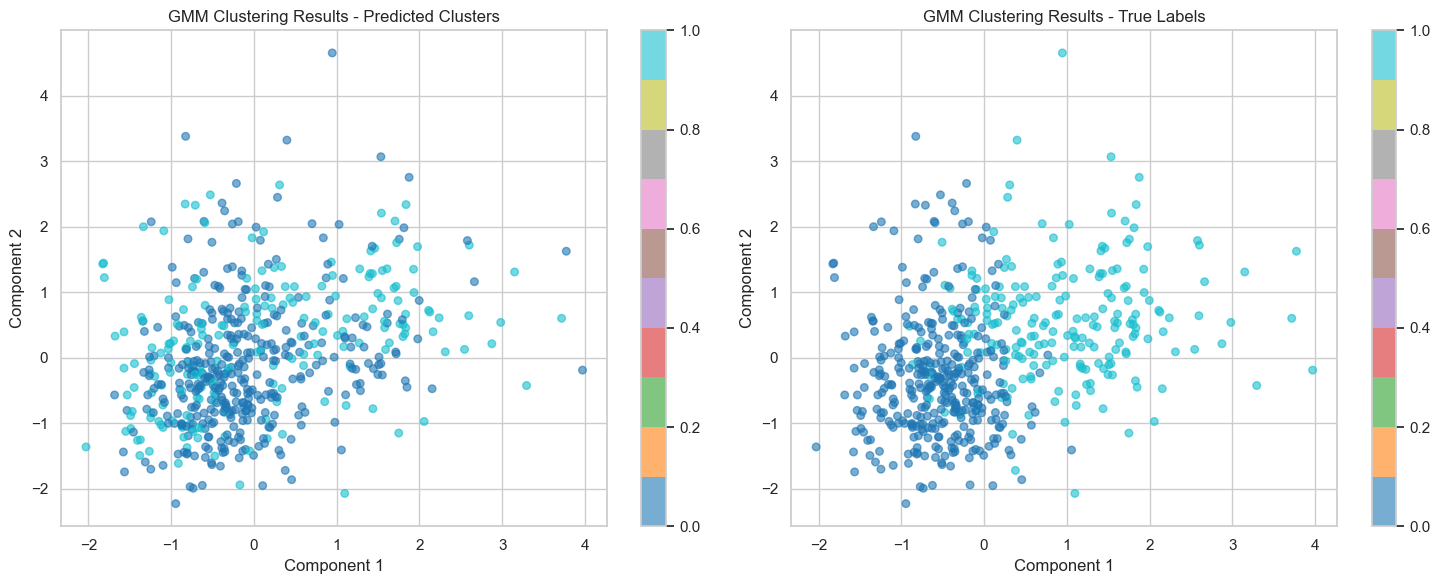

In [100]:
X_2d = X[:, :2]  # Using first two features for 2D projection
plot_2d_projection(X_2d, pred_labels_gmm, true_labels=y, 
                   centers=None, title='GMM Clustering Results')

###########

# Experiment 3: K-Means after PCA
Run K-Means on PCA-reduced breast cancer data (components: 2, 5, 10, 15, 20) to study reconstruction error vs clustering quality. Metrics: silhouette, Davies-Bouldin, Calinski-Harabasz, WCSS, ARI, NMI, purity; plus confusion matrix for best silhouette and 2D projection.

In [101]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from Kmeans import KMeans
from PCA import PCA
import part3

sns.set(style="whitegrid")

In [102]:
# Load and standardize dataset
X_raw, y_true = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X_raw)
print(f"Data shape: {X.shape}, positive class ratio: {y_true.mean():.3f}")

Data shape: (569, 30), positive class ratio: 0.627


In [103]:
# Run PCA -> KMeans across component counts

def run_pca_kmeans(
    X,
    y_true,
    n_components_list,
    k=2,
    init="kmeans++",
    max_iter=300,
    tol=1e-4,
):
    results = {
        "n_components": [],
        "reconstruction_error": [],
        "explained_variance": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "wcss": [],
        "ari": [],
        "nmi": [],
        "purity": [],
        "labels": [],
    }

    for n_comp in n_components_list:
        pca = PCA(n_components=n_comp)
        pca.fit(X)
        X_pca = pca.transform(X)

        rec_err = pca.reconstruction_error(X)
        explained = np.sum(pca.explained_variance_ratio_[:n_comp])

        km = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
        km.fit(X_pca)
        labels = km.labels_

        sil, _ = part3.silhouette_score(X_pca, labels) if k > 1 else (np.nan, None)
        dbi = part3.davies_bouldin_index(X_pca, labels) if k > 1 else np.nan
        chi = part3.calinski_harabasz_index(X_pca, labels) if k > 1 else np.nan
        wcss = part3.within_cluster_sum_of_squares(X_pca, labels)

        ari = part3.adjusted_rand_index(y_true, labels)
        nmi = part3.normalized_mutual_information(y_true, labels)
        purity = part3.purity_score(y_true, labels)

        results["n_components"].append(n_comp)
        results["reconstruction_error"].append(rec_err)
        results["explained_variance"].append(explained)
        results["silhouette"].append(sil)
        results["davies_bouldin"].append(dbi)
        results["calinski_harabasz"].append(chi)
        results["wcss"].append(wcss)
        results["ari"].append(ari)
        results["nmi"].append(nmi)
        results["purity"].append(purity)
        results["labels"].append(labels)

    return results

In [104]:
# Plot helpers

def plot_reconstruction_and_variance(n_components, rec_errors, explained):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(n_components, rec_errors, marker="o", color="red")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Reconstruction Error vs PCA Components")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(n_components, explained, marker="o", color="blue")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Explained Variance (cumulative)")
    plt.title("Explained Variance vs PCA Components")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_clustering_metrics(n_components, results):
    plt.figure(figsize=(14, 12))

    plt.subplot(3, 2, 1)
    plt.plot(n_components, results["silhouette"], marker="o")
    plt.xlabel("PCA Components")
    plt.ylabel("Silhouette")
    plt.title("Silhouette vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 2)
    plt.plot(n_components, results["davies_bouldin"], marker="o", color="orange")
    plt.xlabel("PCA Components")
    plt.ylabel("Davies-Bouldin (lower better)")
    plt.title("Davies-Bouldin vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 3)
    plt.plot(n_components, results["calinski_harabasz"], marker="o", color="green")
    plt.xlabel("PCA Components")
    plt.ylabel("Calinski-Harabasz (higher better)")
    plt.title("Calinski-Harabasz vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 4)
    plt.plot(n_components, results["wcss"], marker="o", color="red")
    plt.xlabel("PCA Components")
    plt.ylabel("WCSS")
    plt.title("WCSS vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 5)
    plt.plot(n_components, results["ari"], marker="o", color="blue")
    plt.xlabel("PCA Components")
    plt.ylabel("Adjusted Rand Index")
    plt.title("ARI vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 6)
    plt.plot(n_components, results["purity"], marker="o", color="brown")
    plt.xlabel("PCA Components")
    plt.ylabel("Purity")
    plt.title("Purity vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion(cm, true_classes, pred_clusters, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {c}" for c in pred_clusters],
        yticklabels=[f"True {c}" for c in true_classes],
    )
    plt.title(title)
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Classes")
    plt.tight_layout()
    plt.show()


def plot_2d_projection(X_2d, labels, true_labels=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette="tab10", s=40, alpha=0.7)
    plt.title("K-Means on 2D PCA projection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if true_labels is not None:
        plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [105]:
# Run experiment and pick best silhouette configuration
n_components_list = [2, 5, 10, 15, 20]

results = run_pca_kmeans(X, y_true, n_components_list, k=2, init="kmeans++")

# Best-by-metric variables (_exp3):
best_sil_idx_exp3 = int(np.nanargmax(results["silhouette"]))
best_sil_n_exp3 = results["n_components"][best_sil_idx_exp3]
best_sil_value_exp3 = results["silhouette"][best_sil_idx_exp3]

best_dbi_idx_exp3 = int(np.nanargmin(results["davies_bouldin"]))
best_dbi_n_exp3 = results["n_components"][best_dbi_idx_exp3]
best_dbi_value_exp3 = results["davies_bouldin"][best_dbi_idx_exp3]

best_ch_idx_exp3 = int(np.nanargmax(results["calinski_harabasz"]))
best_ch_n_exp3 = results["n_components"][best_ch_idx_exp3]
best_ch_value_exp3 = results["calinski_harabasz"][best_ch_idx_exp3]

best_wcss_idx_exp3 = int(np.nanargmin(results["wcss"]))
best_wcss_n_exp3 = results["n_components"][best_wcss_idx_exp3]
best_wcss_value_exp3 = results["wcss"][best_wcss_idx_exp3]

best_ari_idx_exp3 = int(np.nanargmax(results["ari"]))
best_ari_n_exp3 = results["n_components"][best_ari_idx_exp3]
best_ari_value_exp3 = results["ari"][best_ari_idx_exp3]

best_nmi_idx_exp3 = int(np.nanargmax(results["nmi"]))
best_nmi_n_exp3 = results["n_components"][best_nmi_idx_exp3]
best_nmi_value_exp3 = results["nmi"][best_nmi_idx_exp3]

best_purity_idx_exp3 = int(np.nanargmax(results["purity"]))
best_purity_n_exp3 = results["n_components"][best_purity_idx_exp3]
best_purity_value_exp3 = results["purity"][best_purity_idx_exp3]

best_idx = int(np.nanargmax(results["silhouette"]))
best_n = results["n_components"][best_idx]
best_labels = results["labels"][best_idx]
cm, true_classes, pred_clusters = part3.confusion_matrix(y_true, best_labels)

print(f"Best silhouette at n_components={best_n}: score={results['silhouette'][best_idx]:.3f}")
print(
    f"Reconstruction error={results['reconstruction_error'][best_idx]:.4f}, "
    f"Explained variance={results['explained_variance'][best_idx]:.3f}"
)

print("\nSummary metrics (per n_components):")
for idx, n_comp in enumerate(results["n_components"]):
    print(
        f"n={n_comp:>2} | rec_err={results['reconstruction_error'][idx]:.4f} "
        f"expl_var={results['explained_variance'][idx]:.3f} sil={results['silhouette'][idx]:.3f} "
        f"dbi={results['davies_bouldin'][idx]:.3f} chi={results['calinski_harabasz'][idx]:.2f} "
        f"wcss={results['wcss'][idx]:.2f} ari={results['ari'][idx]:.3f} "
        f"nmi={results['nmi'][idx]:.3f} purity={results['purity'][idx]:.3f}"
    )

Best silhouette at n_components=2: score=0.508
Reconstruction error=0.3676, Explained variance=0.632

Summary metrics (per n_components):
n= 2 | rec_err=0.3676 expl_var=0.632 sil=0.508 dbi=0.847 chi=580.88 wcss=5332.56 ari=0.659 nmi=0.540 purity=0.907
n= 5 | rec_err=0.1527 expl_var=0.847 sil=0.393 dbi=1.141 chi=345.07 wcss=8991.83 ari=0.671 nmi=0.555 purity=0.910
n=10 | rec_err=0.0484 expl_var=0.952 sil=0.356 dbi=1.268 chi=288.10 wcss=10770.55 ari=0.654 nmi=0.532 purity=0.905
n=15 | rec_err=0.0135 expl_var=0.986 sil=0.346 dbi=1.306 chi=273.07 wcss=11365.57 ari=0.659 nmi=0.538 purity=0.907
n=20 | rec_err=0.0044 expl_var=0.996 sil=0.346 dbi=1.307 chi=269.45 wcss=11519.97 ari=0.671 nmi=0.555 purity=0.910


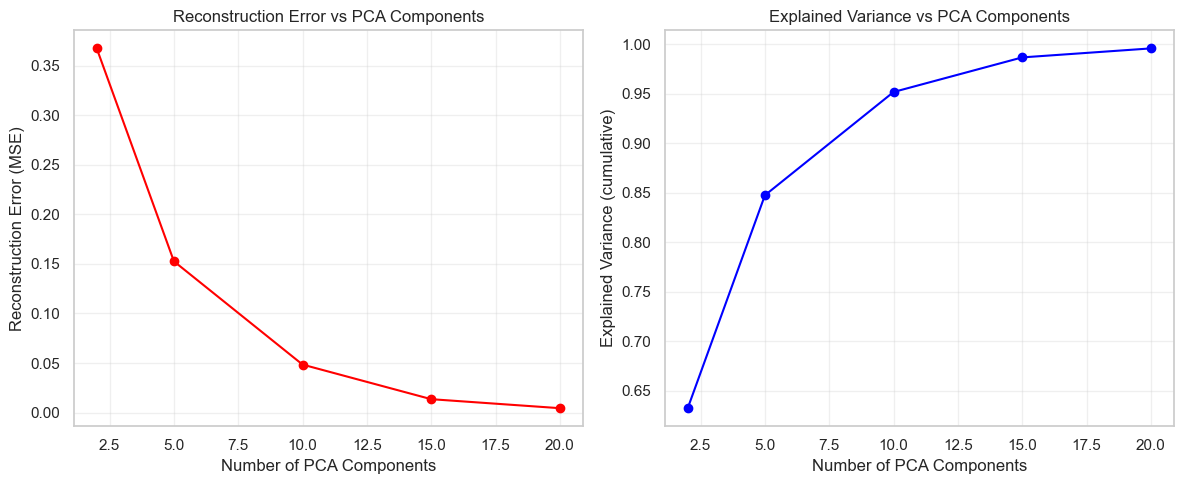

In [106]:
# Plots: reconstruction error and explained variance
plot_reconstruction_and_variance(
    results["n_components"],
    results["reconstruction_error"],
    results["explained_variance"],
)

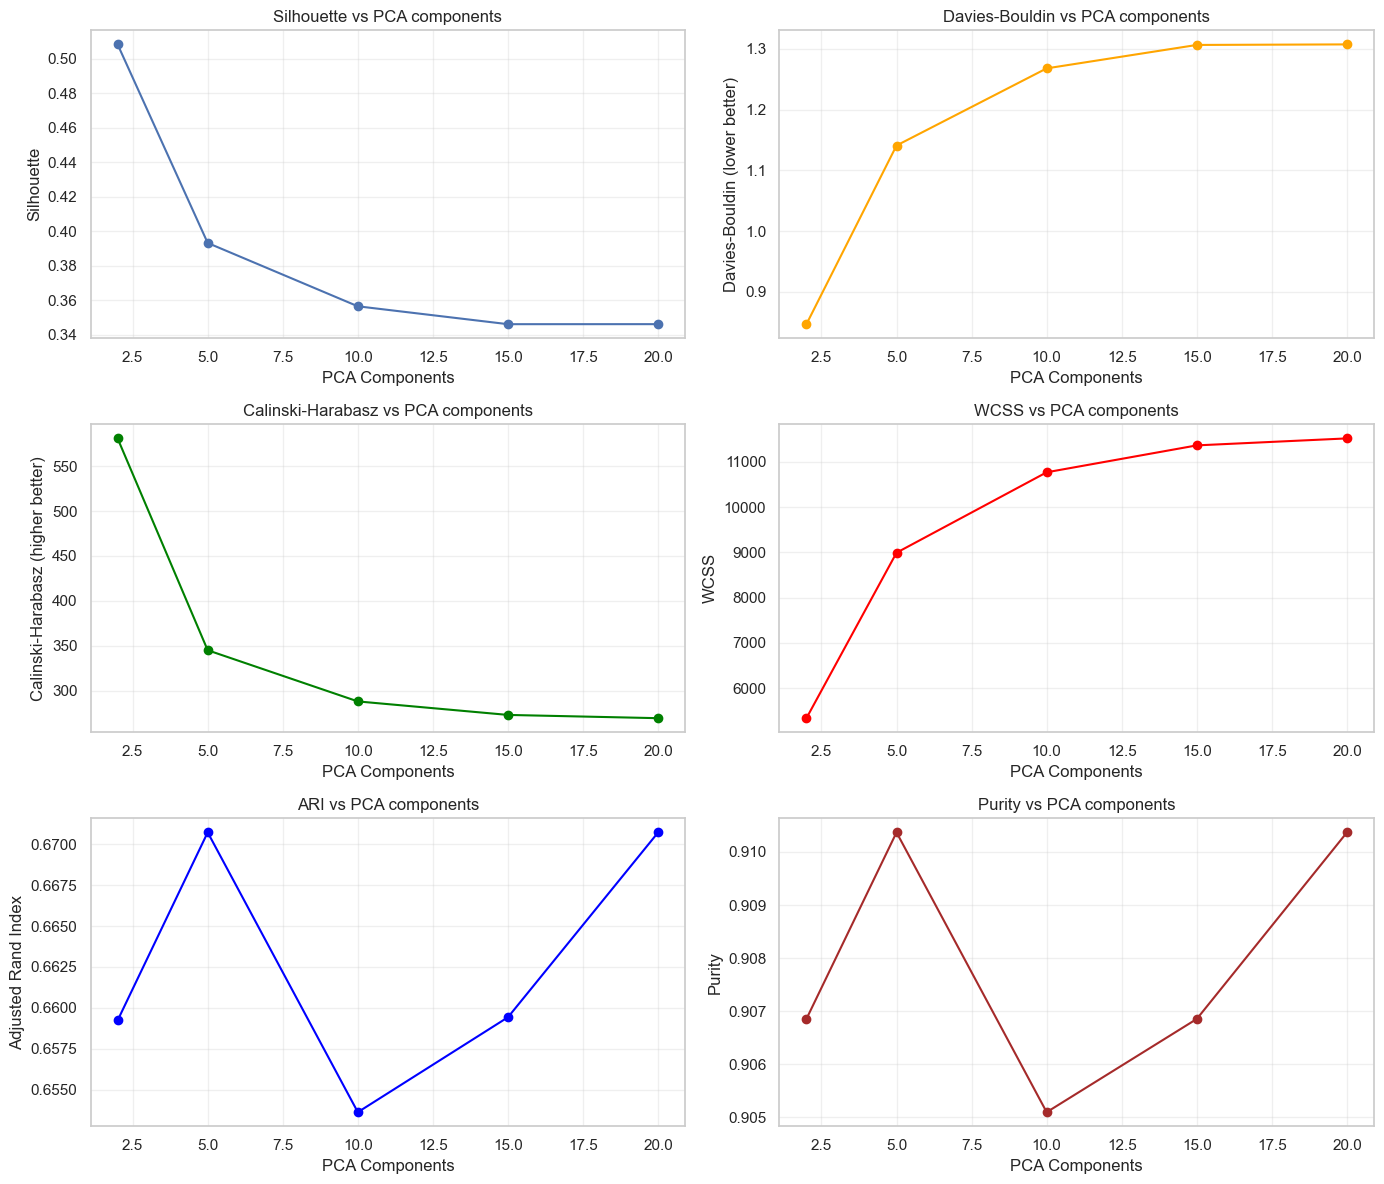

In [107]:
# Plots: clustering metrics across PCA dimensions
plot_clustering_metrics(results["n_components"], results)

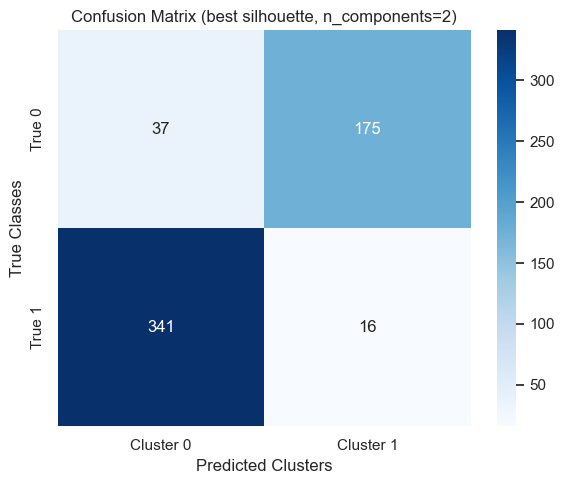

In [108]:
# Confusion matrix for best silhouette setup
title = f"Confusion Matrix (best silhouette, n_components={best_n})"
plot_confusion(cm, true_classes, pred_clusters, title)

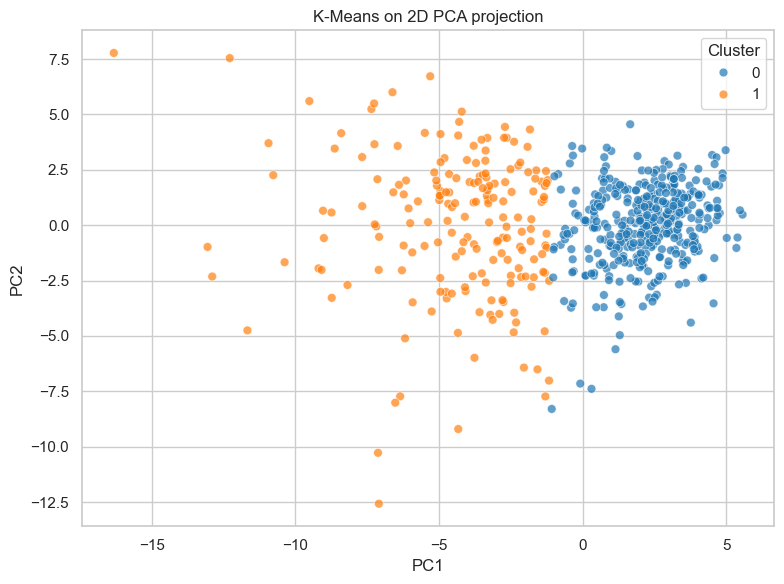

In [109]:
# 2D visualization when n_components includes 2
if 2 in n_components_list:
    pca2 = PCA(n_components=2)
    pca2.fit(X)
    X2 = pca2.transform(X)
    km2 = KMeans(k=2, init="kmeans++", max_iter=300, tol=1e-4)
    km2.fit(X2)
    plot_2d_projection(X2, km2.labels_, y_true)
else:
    print("n_components=2 not in list; skipping 2D projection.")

In [110]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from Kmeans import KMeans
from PCA import PCA
import part3

sns.set(style="whitegrid")

In [111]:
# Load and standardize dataset
X_raw, y_true = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X_raw)
print(f"Data shape: {X.shape}, positive class ratio: {y_true.mean():.3f}")

Data shape: (569, 30), positive class ratio: 0.627


In [112]:
# Run PCA -> KMeans across component counts

def run_pca_kmeans(
    X,
    y_true,
    n_components_list,
    k=2,
    init="kmeans++",
    max_iter=300,
    tol=1e-4,
):
    results = {
        "n_components": [],
        "reconstruction_error": [],
        "explained_variance": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "wcss": [],
        "ari": [],
        "nmi": [],
        "purity": [],
        "labels": [],
    }

    for n_comp in n_components_list:
        pca = PCA(n_components=n_comp)
        pca.fit(X)
        X_pca = pca.transform(X)

        rec_err = pca.reconstruction_error(X)
        explained = np.sum(pca.explained_variance_ratio_[:n_comp])

        km = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
        km.fit(X_pca)
        labels = km.labels_

        sil, _ = part3.silhouette_score(X_pca, labels) if k > 1 else (np.nan, None)
        dbi = part3.davies_bouldin_index(X_pca, labels) if k > 1 else np.nan
        chi = part3.calinski_harabasz_index(X_pca, labels) if k > 1 else np.nan
        wcss = part3.within_cluster_sum_of_squares(X_pca, labels)

        ari = part3.adjusted_rand_index(y_true, labels)
        nmi = part3.normalized_mutual_information(y_true, labels)
        purity = part3.purity_score(y_true, labels)

        results["n_components"].append(n_comp)
        results["reconstruction_error"].append(rec_err)
        results["explained_variance"].append(explained)
        results["silhouette"].append(sil)
        results["davies_bouldin"].append(dbi)
        results["calinski_harabasz"].append(chi)
        results["wcss"].append(wcss)
        results["ari"].append(ari)
        results["nmi"].append(nmi)
        results["purity"].append(purity)
        results["labels"].append(labels)

    return results

In [113]:
# Plot helpers

def plot_reconstruction_and_variance(n_components, rec_errors, explained):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(n_components, rec_errors, marker="o", color="red")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Reconstruction Error vs PCA Components")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(n_components, explained, marker="o", color="blue")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Explained Variance (cumulative)")
    plt.title("Explained Variance vs PCA Components")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_clustering_metrics(n_components, results):
    plt.figure(figsize=(14, 12))

    plt.subplot(3, 2, 1)
    plt.plot(n_components, results["silhouette"], marker="o")
    plt.xlabel("PCA Components")
    plt.ylabel("Silhouette")
    plt.title("Silhouette vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 2)
    plt.plot(n_components, results["davies_bouldin"], marker="o", color="orange")
    plt.xlabel("PCA Components")
    plt.ylabel("Davies-Bouldin (lower better)")
    plt.title("Davies-Bouldin vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 3)
    plt.plot(n_components, results["calinski_harabasz"], marker="o", color="green")
    plt.xlabel("PCA Components")
    plt.ylabel("Calinski-Harabasz (higher better)")
    plt.title("Calinski-Harabasz vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 4)
    plt.plot(n_components, results["wcss"], marker="o", color="red")
    plt.xlabel("PCA Components")
    plt.ylabel("WCSS")
    plt.title("WCSS vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 5)
    plt.plot(n_components, results["ari"], marker="o", color="blue")
    plt.xlabel("PCA Components")
    plt.ylabel("Adjusted Rand Index")
    plt.title("ARI vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 6)
    plt.plot(n_components, results["purity"], marker="o", color="brown")
    plt.xlabel("PCA Components")
    plt.ylabel("Purity")
    plt.title("Purity vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion(cm, true_classes, pred_clusters, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {c}" for c in pred_clusters],
        yticklabels=[f"True {c}" for c in true_classes],
    )
    plt.title(title)
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Classes")
    plt.tight_layout()
    plt.show()


def plot_2d_projection(X_2d, labels, true_labels=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette="tab10", s=40, alpha=0.7)
    plt.title("K-Means on 2D PCA projection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if true_labels is not None:
        plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [114]:
# Run experiment and pick best silhouette configuration
n_components_list = [2, 5, 10, 15, 20]

results = run_pca_kmeans(X, y_true, n_components_list, k=2, init="kmeans++")

best_idx = int(np.nanargmax(results["silhouette"]))
best_n = results["n_components"][best_idx]
best_labels = results["labels"][best_idx]
cm, true_classes, pred_clusters = part3.confusion_matrix(y_true, best_labels)

print(f"Best silhouette at n_components={best_n}: score={results['silhouette'][best_idx]:.3f}")
print(
    f"Reconstruction error={results['reconstruction_error'][best_idx]:.4f}, "
    f"Explained variance={results['explained_variance'][best_idx]:.3f}"
)

print("\nSummary metrics (per n_components):")
for idx, n_comp in enumerate(results["n_components"]):
    print(
        f"n={n_comp:>2} | rec_err={results['reconstruction_error'][idx]:.4f} "
        f"expl_var={results['explained_variance'][idx]:.3f} sil={results['silhouette'][idx]:.3f} "
        f"dbi={results['davies_bouldin'][idx]:.3f} chi={results['calinski_harabasz'][idx]:.2f} "
        f"wcss={results['wcss'][idx]:.2f} ari={results['ari'][idx]:.3f} "
        f"nmi={results['nmi'][idx]:.3f} purity={results['purity'][idx]:.3f}"
    )

Best silhouette at n_components=2: score=0.508
Reconstruction error=0.3676, Explained variance=0.632

Summary metrics (per n_components):
n= 2 | rec_err=0.3676 expl_var=0.632 sil=0.508 dbi=0.847 chi=580.88 wcss=5332.56 ari=0.659 nmi=0.540 purity=0.907
n= 5 | rec_err=0.1527 expl_var=0.847 sil=0.393 dbi=1.141 chi=345.07 wcss=8991.83 ari=0.671 nmi=0.555 purity=0.910
n=10 | rec_err=0.0484 expl_var=0.952 sil=0.355 dbi=1.263 chi=288.08 wcss=10770.81 ari=0.671 nmi=0.552 purity=0.910
n=15 | rec_err=0.0135 expl_var=0.986 sil=0.348 dbi=1.295 chi=273.07 wcss=11365.60 ari=0.677 nmi=0.562 purity=0.912
n=20 | rec_err=0.0044 expl_var=0.996 sil=0.346 dbi=1.304 chi=269.43 wcss=11520.20 ari=0.677 nmi=0.562 purity=0.912


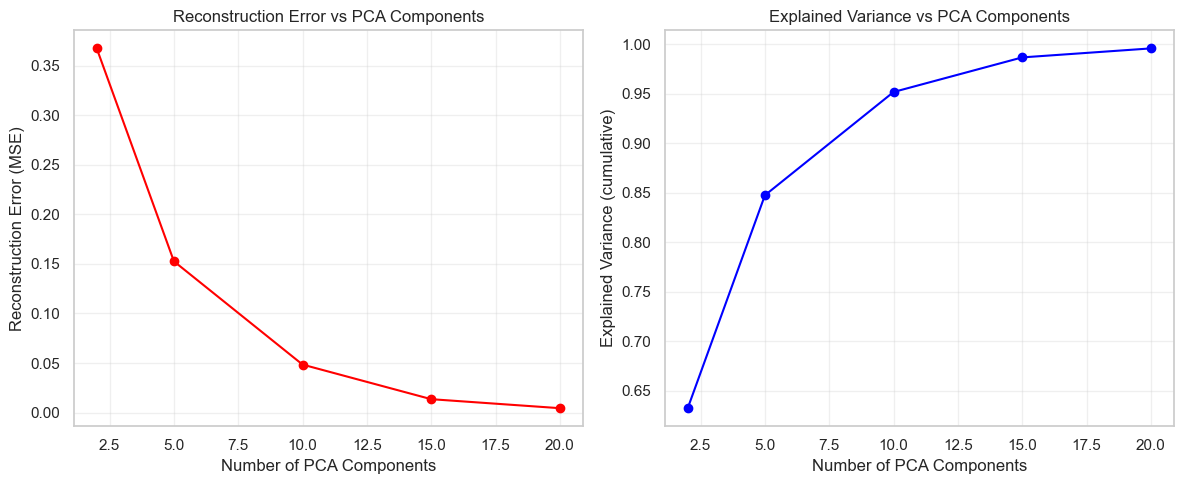

In [115]:
# Plots: reconstruction error and explained variance
plot_reconstruction_and_variance(
    results["n_components"],
    results["reconstruction_error"],
    results["explained_variance"],
)

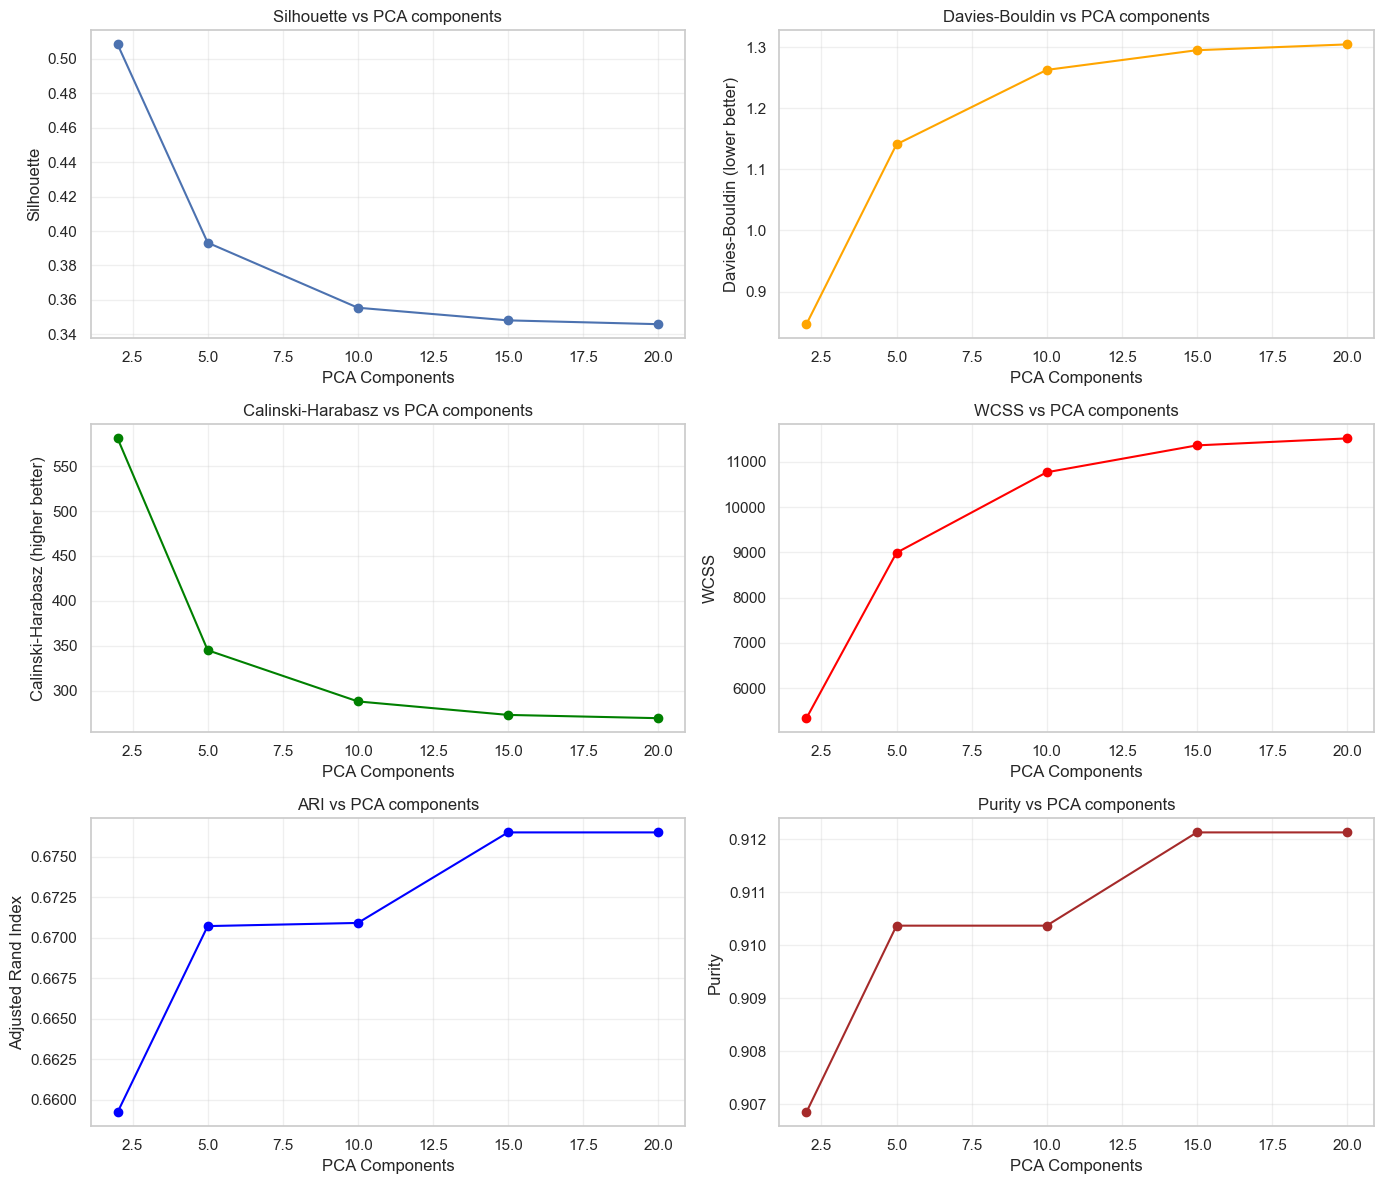

In [116]:
# Plots: clustering metrics across PCA dimensions
plot_clustering_metrics(results["n_components"], results)

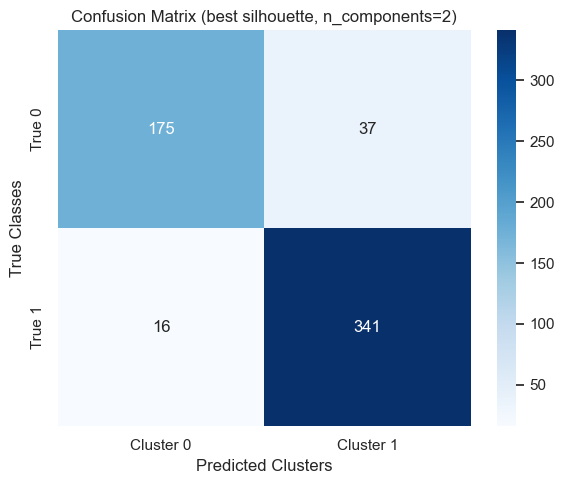

In [117]:
# Confusion matrix for best silhouette setup
title = f"Confusion Matrix (best silhouette, n_components={best_n})"
plot_confusion(cm, true_classes, pred_clusters, title)

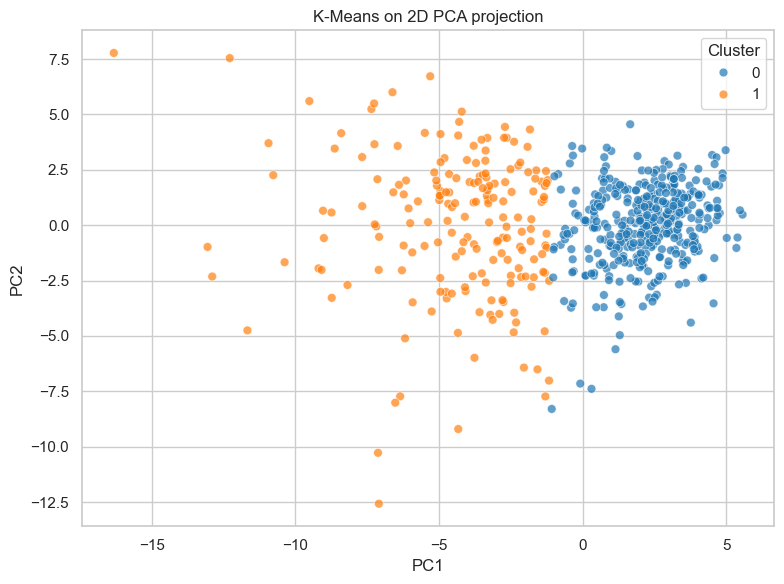

In [118]:
# 2D visualization when n_components includes 2
if 2 in n_components_list:
    pca2 = PCA(n_components=2)
    pca2.fit(X)
    X2 = pca2.transform(X)
    km2 = KMeans(k=2, init="kmeans++", max_iter=300, tol=1e-4)
    km2.fit(X2)
    plot_2d_projection(X2, km2.labels_, y_true)
else:
    print("n_components=2 not in list; skipping 2D projection.")

# Experiment 4: GMM after PCA

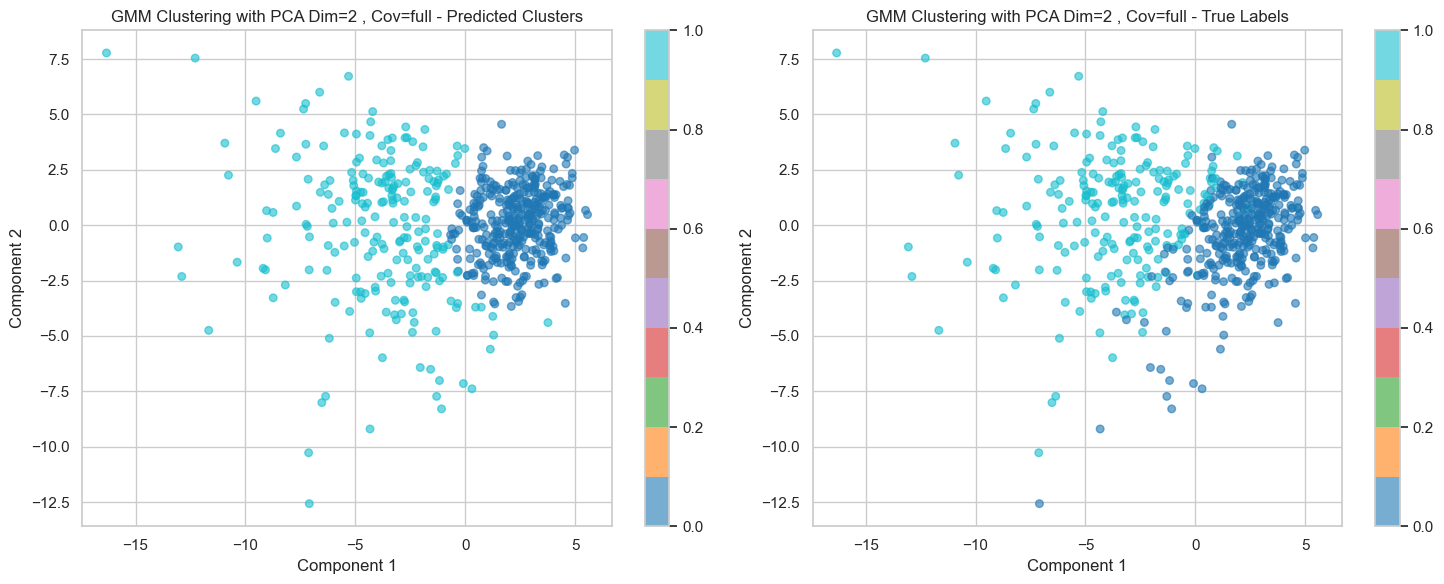


Confusion Matrix for PCA Dim=2, Covariance=full:
[[327  30]
 [ 28 184]]
PCA Dim=2, Covariance=full | Silhouette=0.4871, ARI=0.6318


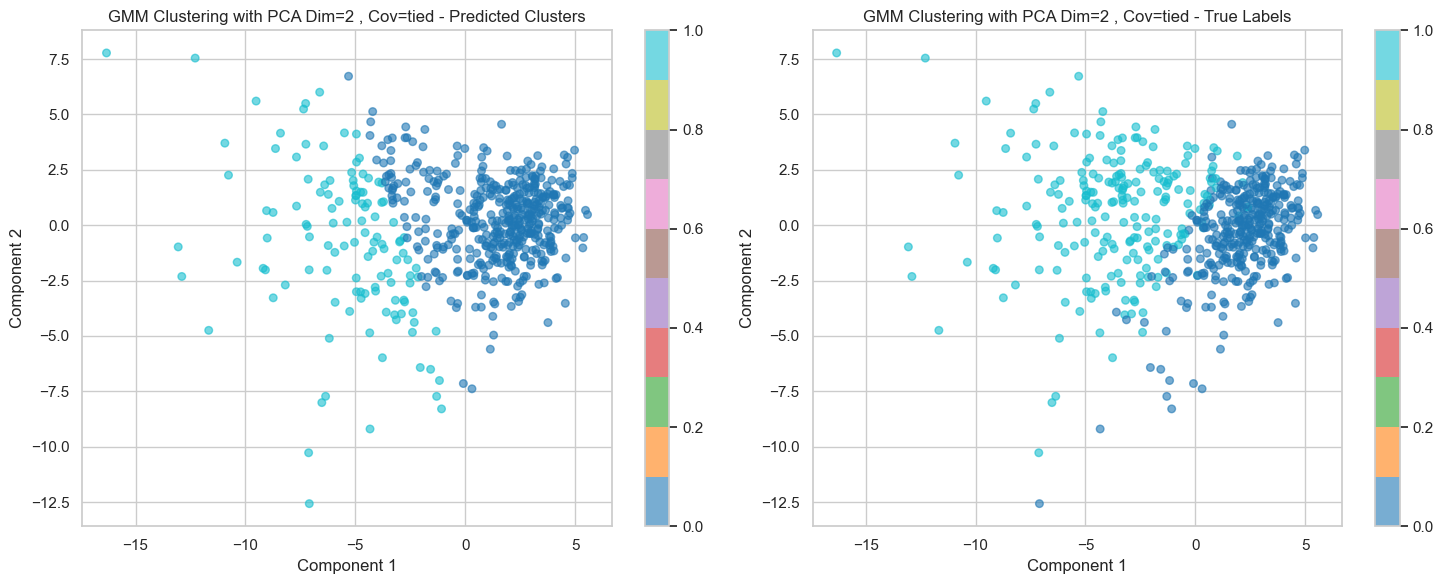


Confusion Matrix for PCA Dim=2, Covariance=tied:
[[346  11]
 [102 110]]
PCA Dim=2, Covariance=tied | Silhouette=0.4901, ARI=0.3487


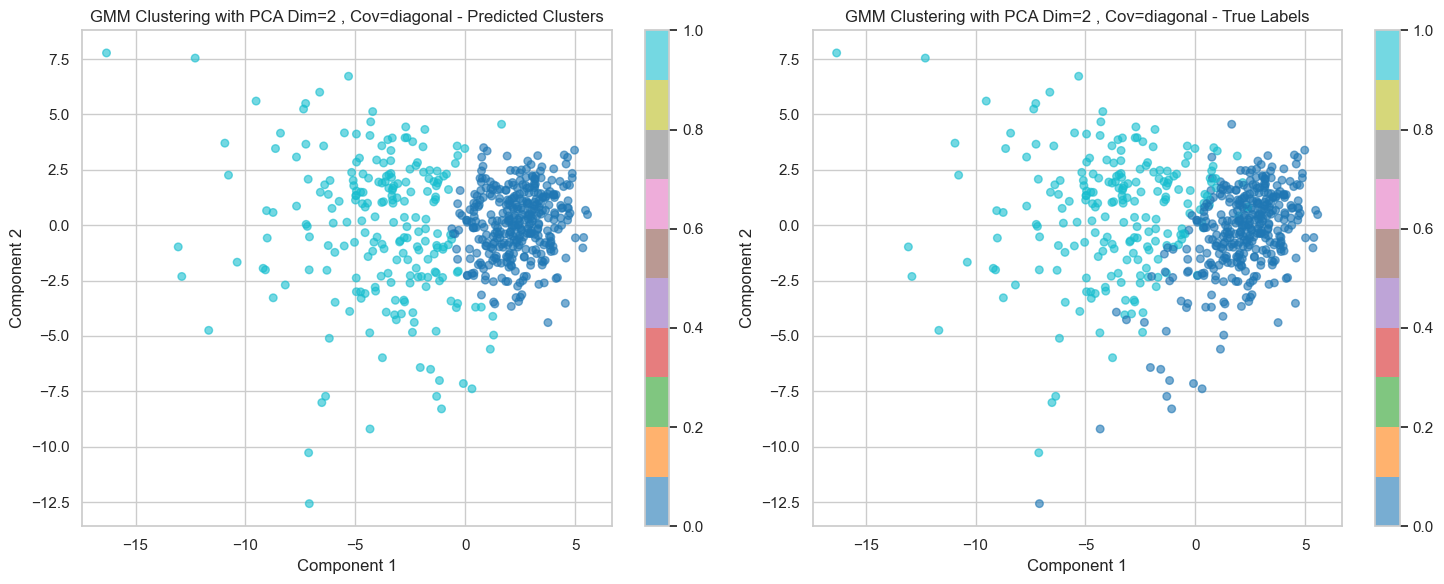


Confusion Matrix for PCA Dim=2, Covariance=diagonal:
[[326  31]
 [ 26 186]]
PCA Dim=2, Covariance=diagonal | Silhouette=0.4851, ARI=0.6375


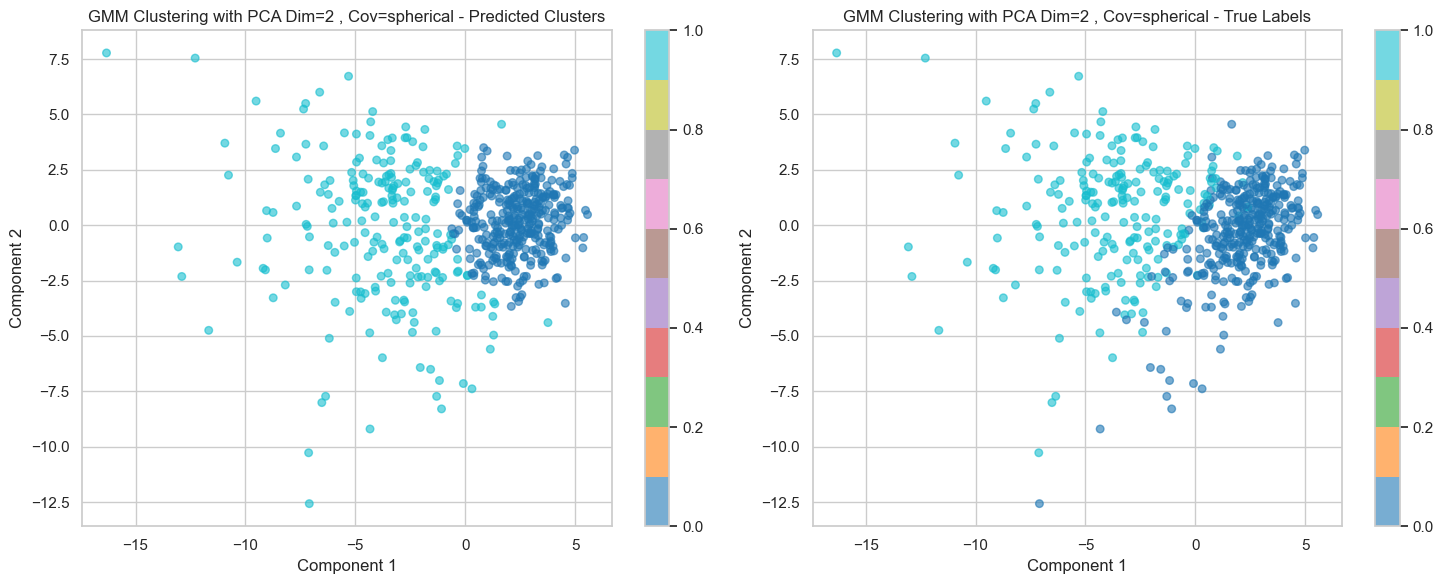


Confusion Matrix for PCA Dim=2, Covariance=spherical:
[[320  37]
 [ 25 187]]
PCA Dim=2, Covariance=spherical | Silhouette=0.4742, ARI=0.6099


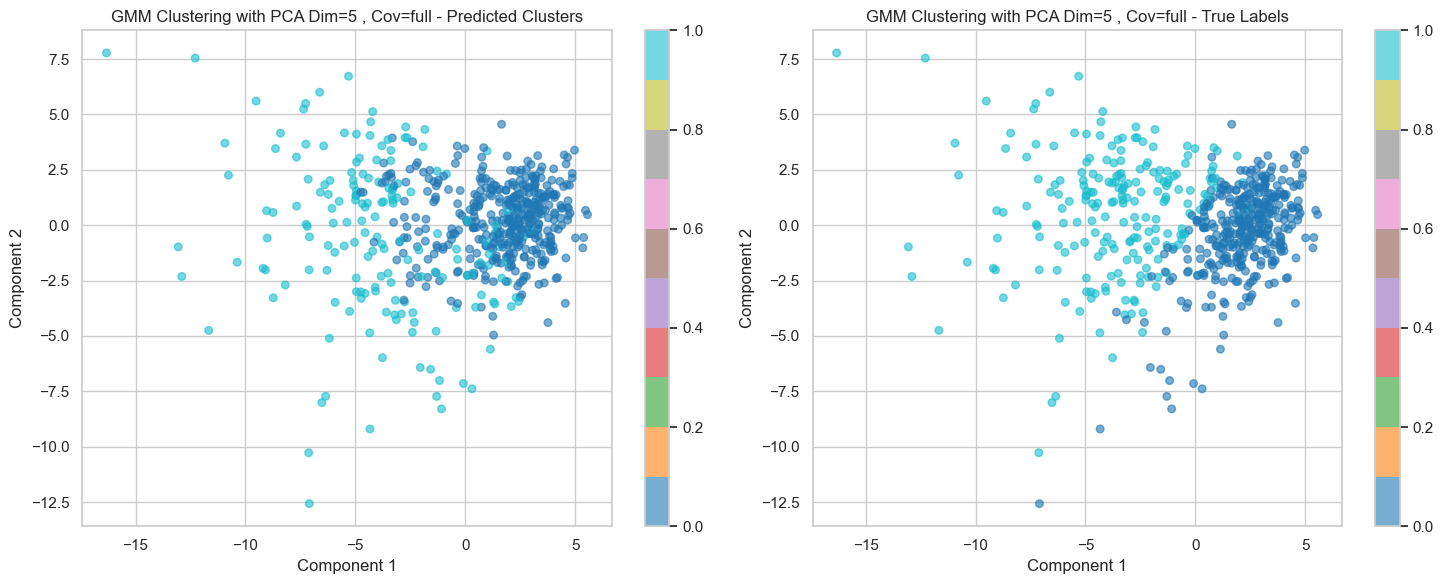


Confusion Matrix for PCA Dim=5, Covariance=full:
[[313  44]
 [ 88 124]]
PCA Dim=5, Covariance=full | Silhouette=0.3298, ARI=0.2785


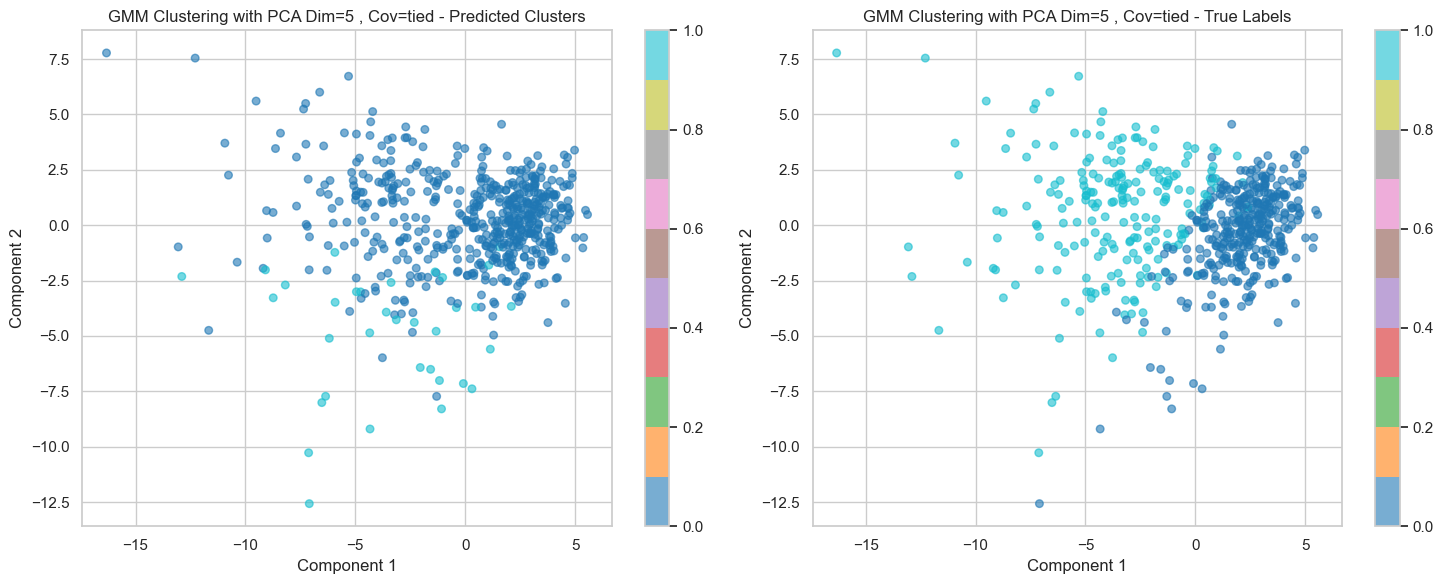


Confusion Matrix for PCA Dim=5, Covariance=tied:
[[337  20]
 [198  14]]
PCA Dim=5, Covariance=tied | Silhouette=0.3724, ARI=0.0041


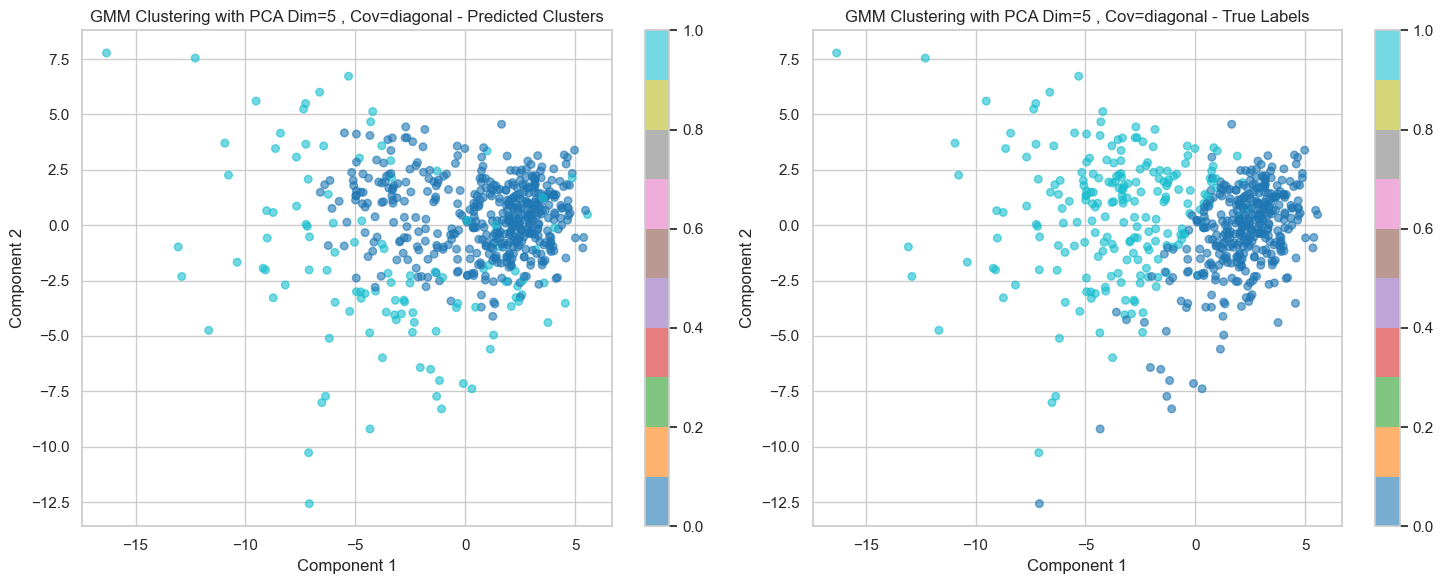


Confusion Matrix for PCA Dim=5, Covariance=diagonal:
[[315  42]
 [141  71]]
PCA Dim=5, Covariance=diagonal | Silhouette=0.3413, ARI=0.1052


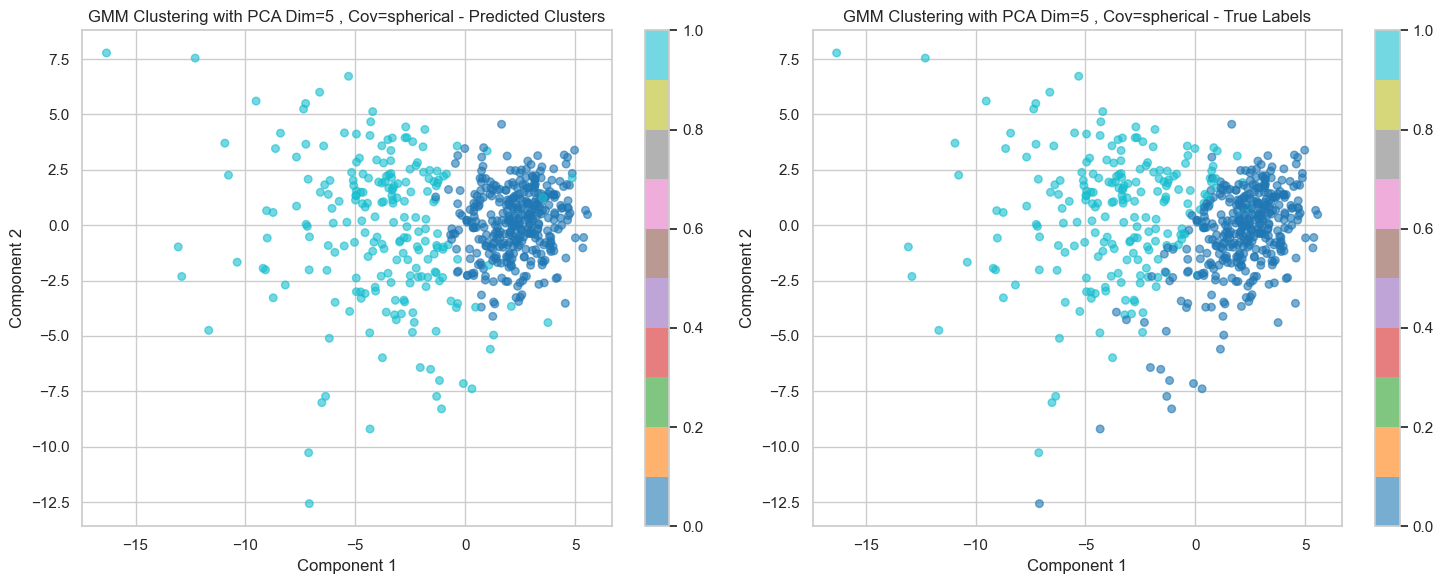


Confusion Matrix for PCA Dim=5, Covariance=spherical:
[[325  32]
 [ 32 180]]
PCA Dim=5, Covariance=spherical | Silhouette=0.3721, ARI=0.5984


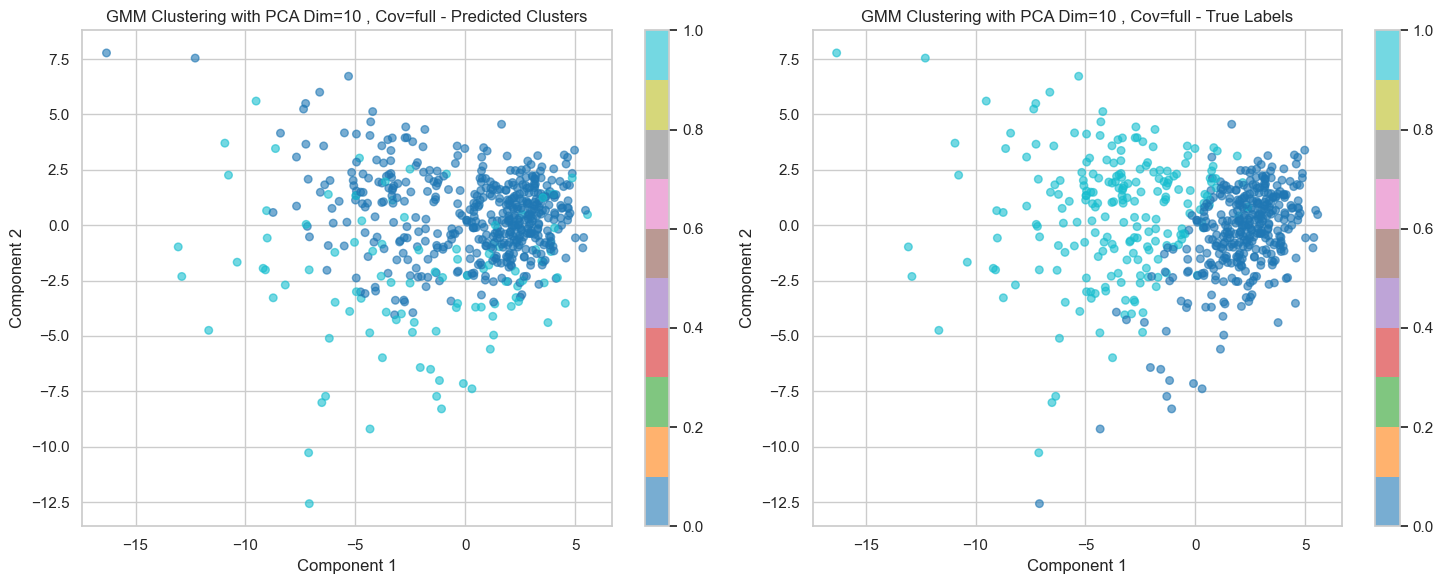


Confusion Matrix for PCA Dim=10, Covariance=full:
[[303  54]
 [167  45]]
PCA Dim=10, Covariance=full | Silhouette=0.2771, ARI=0.0219


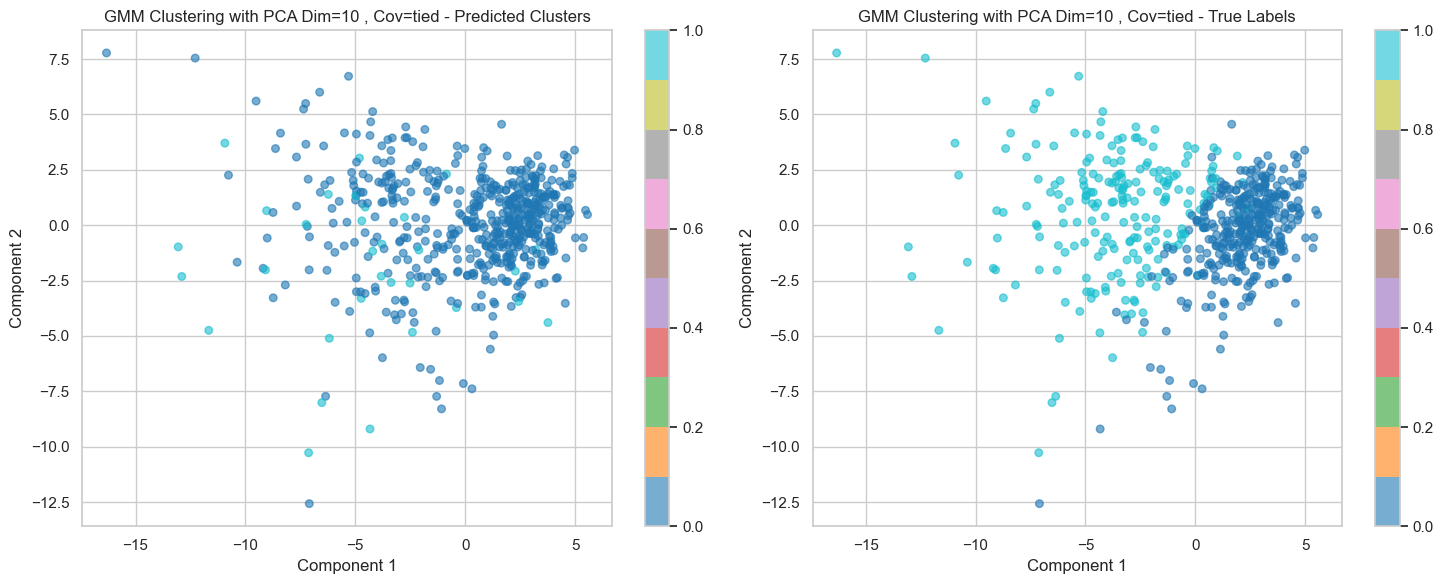


Confusion Matrix for PCA Dim=10, Covariance=tied:
[[351   6]
 [187  25]]
PCA Dim=10, Covariance=tied | Silhouette=0.3213, ARI=0.0544


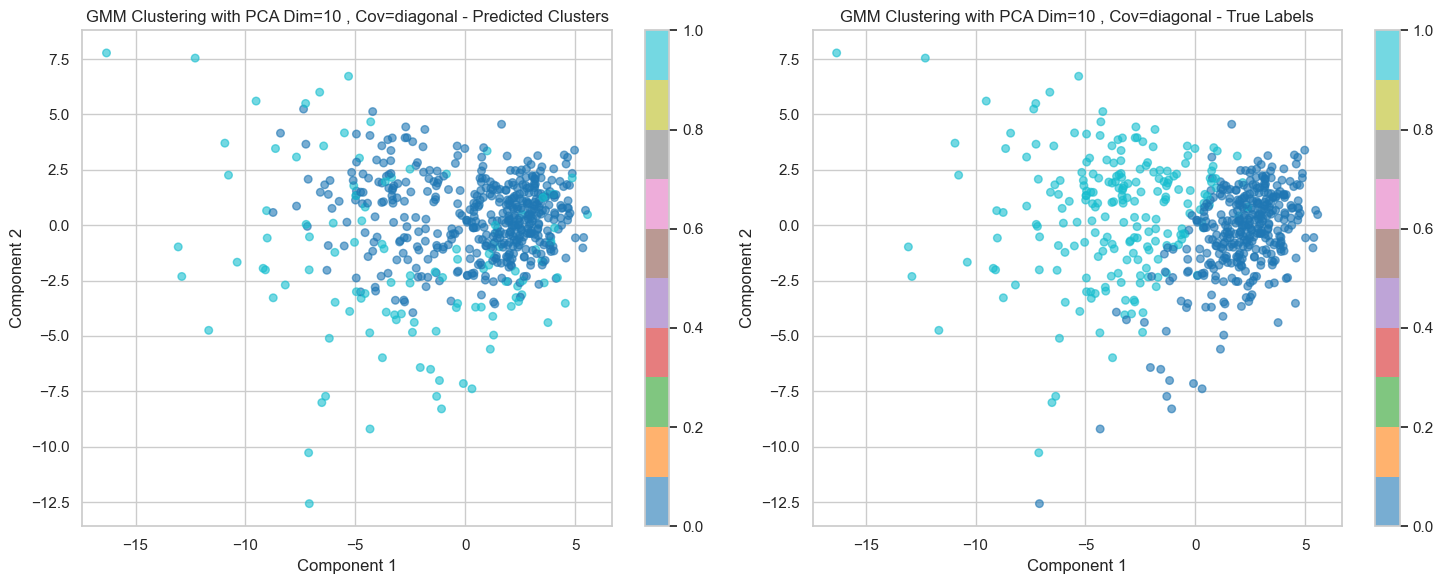


Confusion Matrix for PCA Dim=10, Covariance=diagonal:
[[302  55]
 [154  58]]
PCA Dim=10, Covariance=diagonal | Silhouette=0.2933, ARI=0.0469


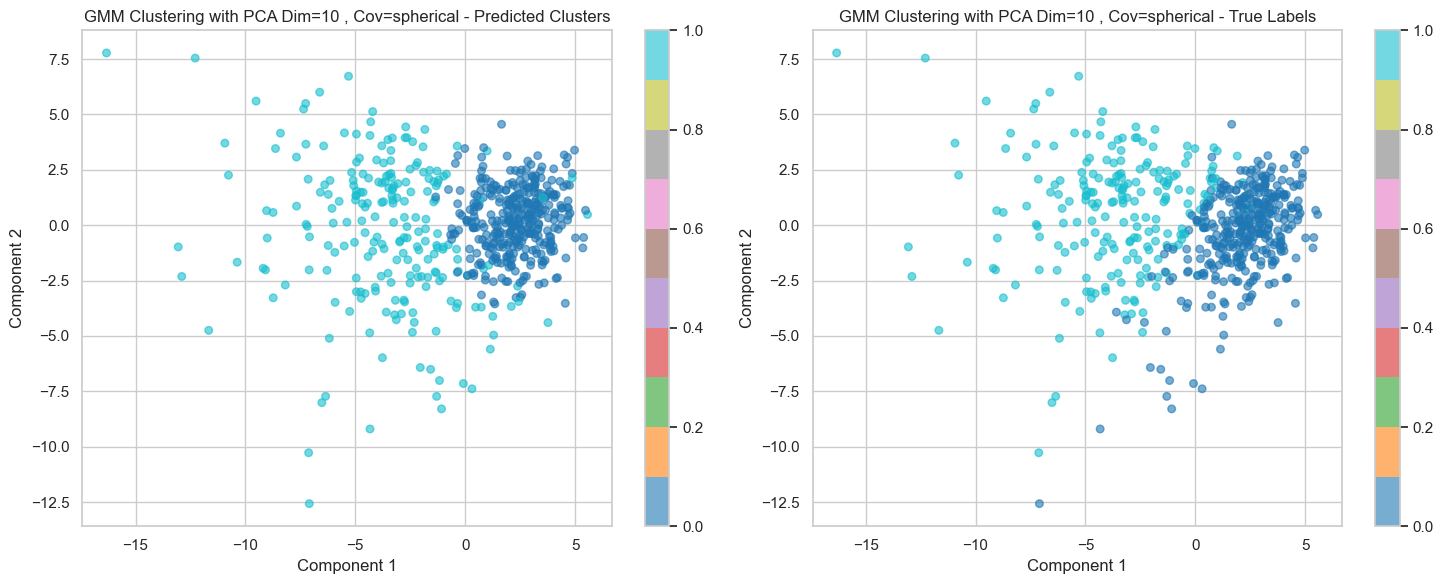


Confusion Matrix for PCA Dim=10, Covariance=spherical:
[[316  41]
 [ 31 181]]
PCA Dim=10, Covariance=spherical | Silhouette=0.3260, ARI=0.5558


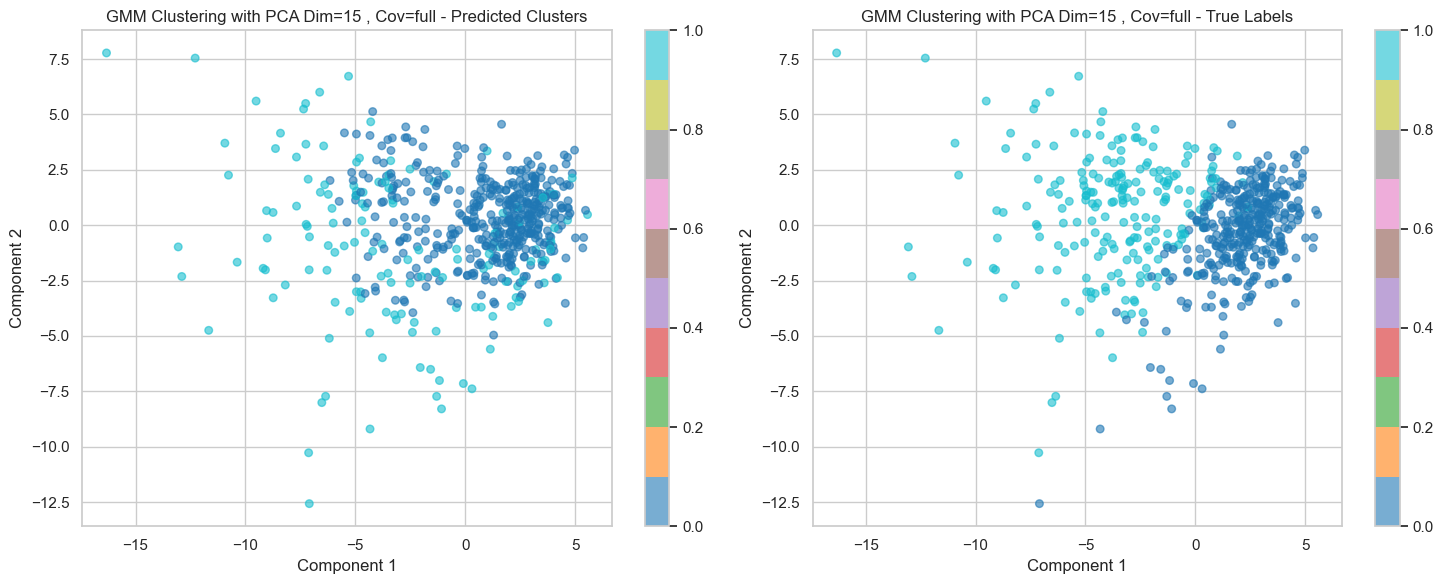


Confusion Matrix for PCA Dim=15, Covariance=full:
[[302  55]
 [126  86]]
PCA Dim=15, Covariance=full | Silhouette=0.2811, ARI=0.1167


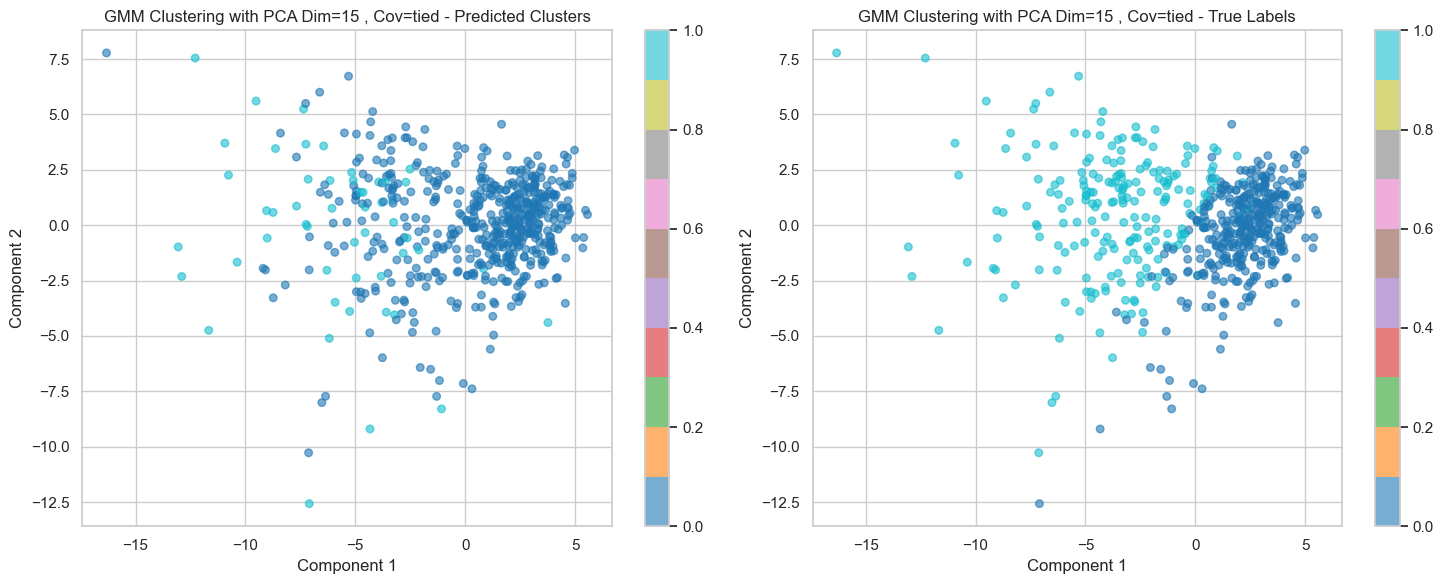


Confusion Matrix for PCA Dim=15, Covariance=tied:
[[351   6]
 [167  45]]
PCA Dim=15, Covariance=tied | Silhouette=0.3211, ARI=0.1144


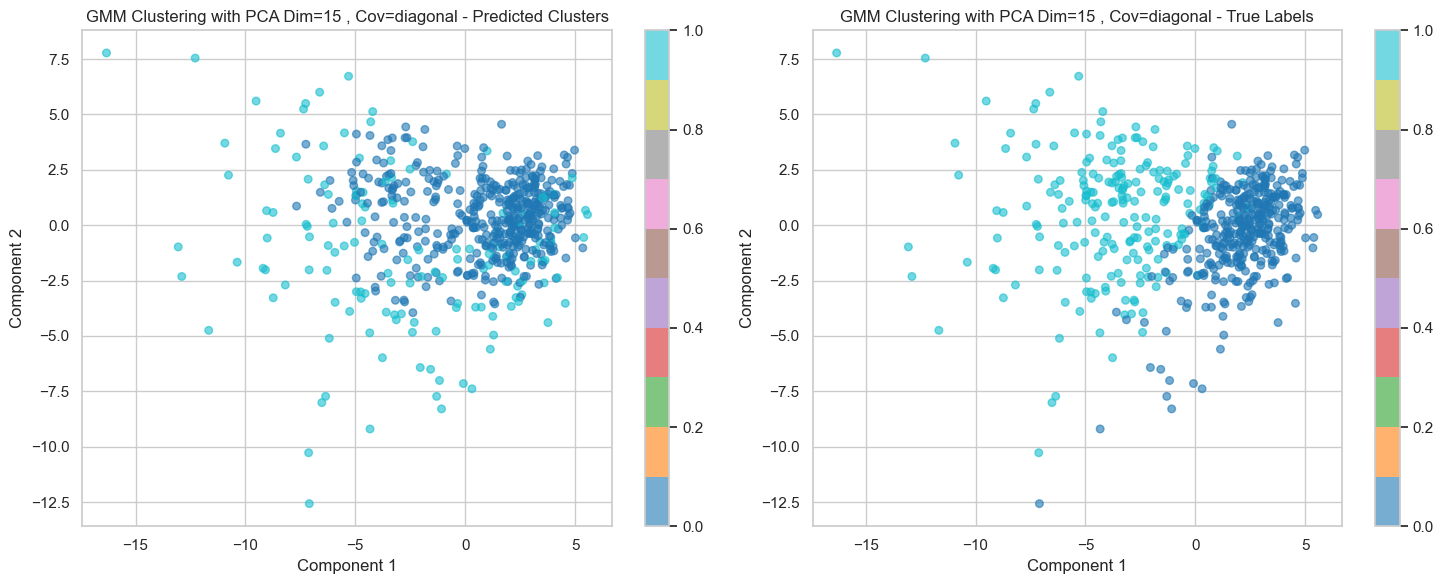


Confusion Matrix for PCA Dim=15, Covariance=diagonal:
[[293  64]
 [135  77]]
PCA Dim=15, Covariance=diagonal | Silhouette=0.2682, ARI=0.0739


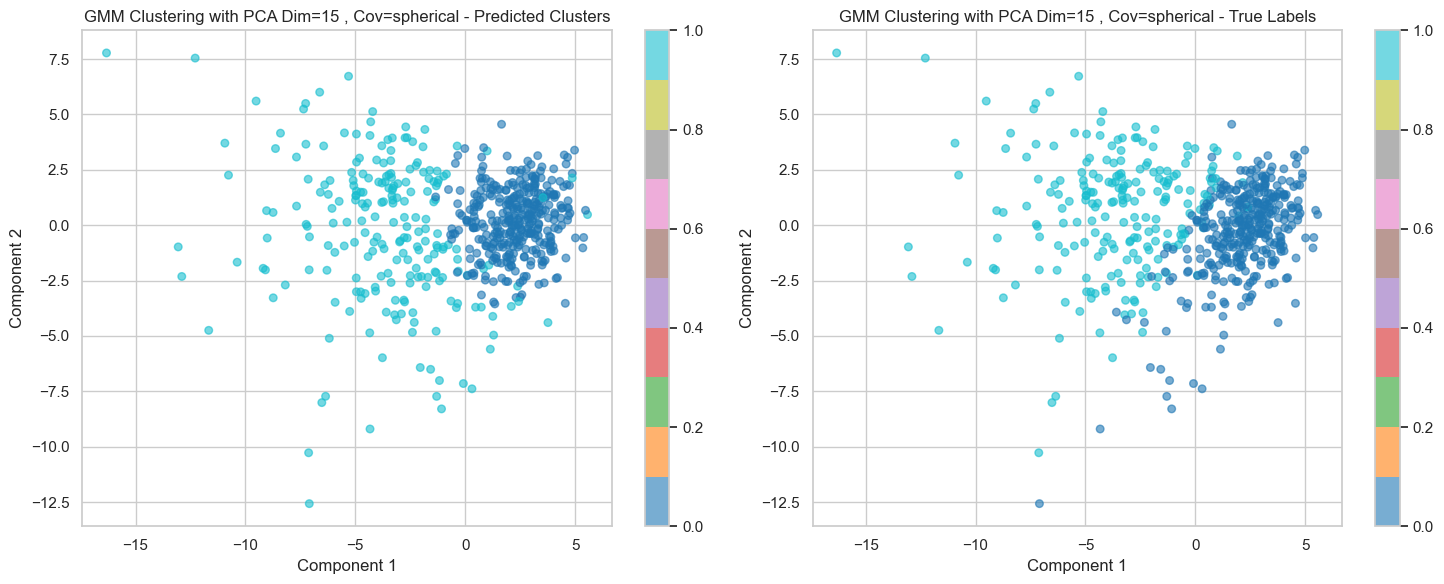


Confusion Matrix for PCA Dim=15, Covariance=spherical:
[[317  40]
 [ 31 181]]
PCA Dim=15, Covariance=spherical | Silhouette=0.3181, ARI=0.5611


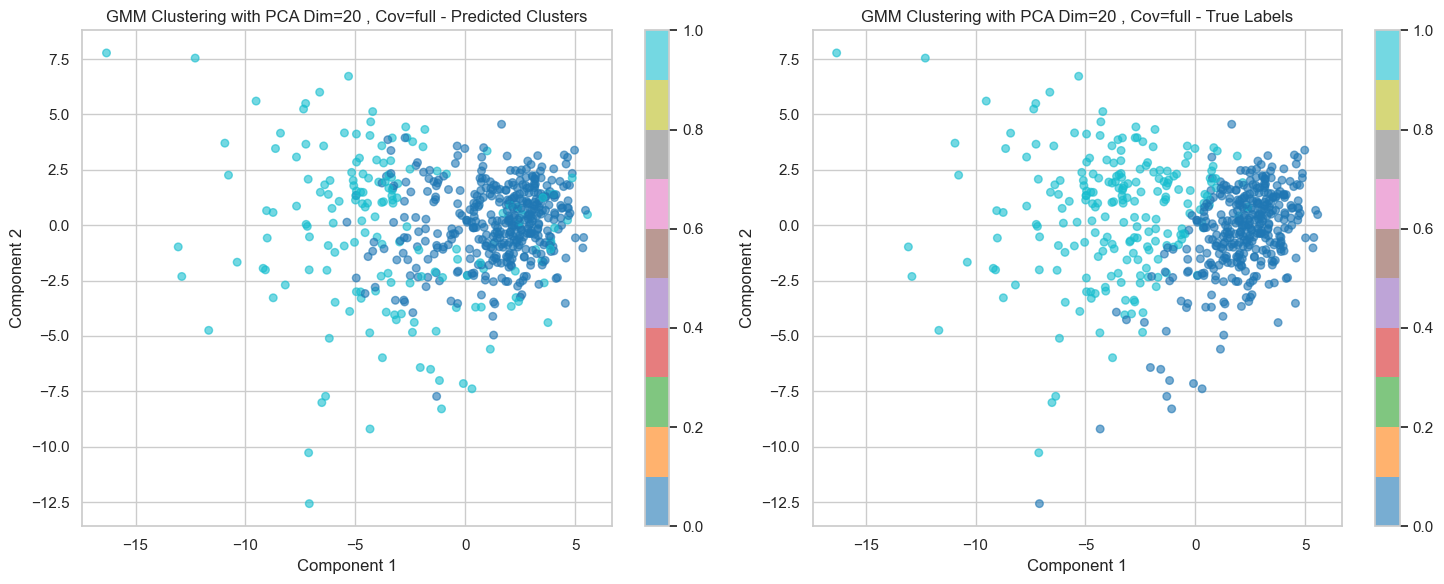


Confusion Matrix for PCA Dim=20, Covariance=full:
[[311  46]
 [ 94 118]]
PCA Dim=20, Covariance=full | Silhouette=0.2912, ARI=0.2482


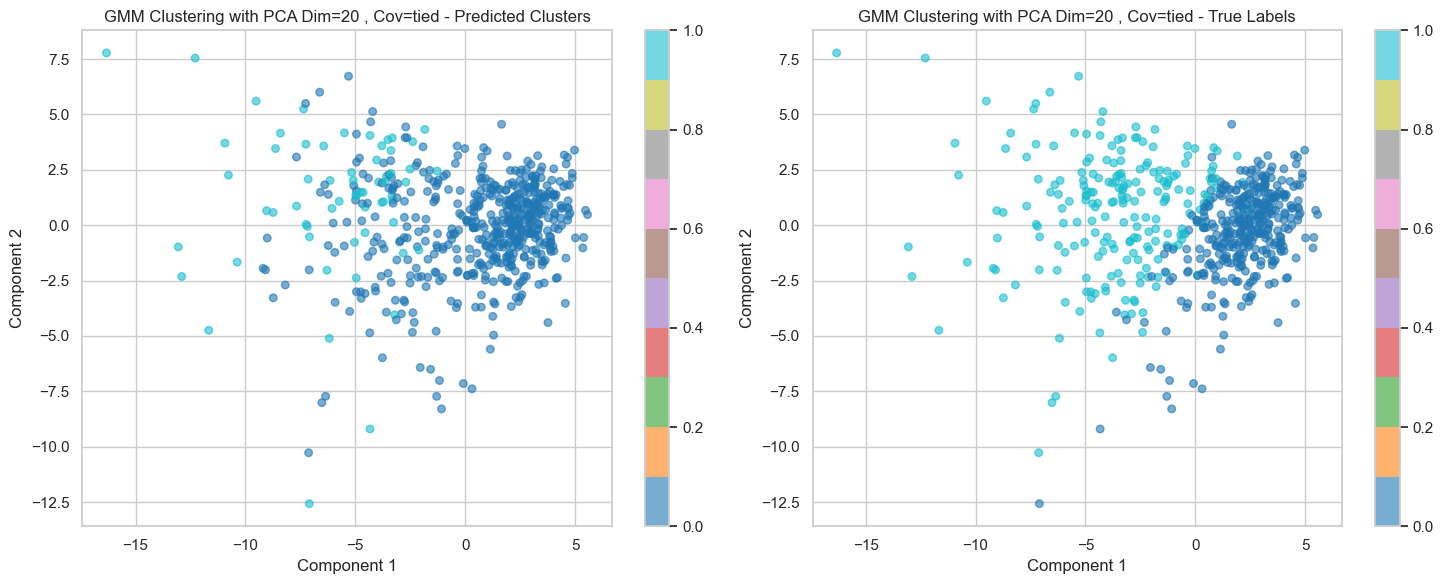


Confusion Matrix for PCA Dim=20, Covariance=tied:
[[355   2]
 [152  60]]
PCA Dim=20, Covariance=tied | Silhouette=0.3129, ARI=0.1772


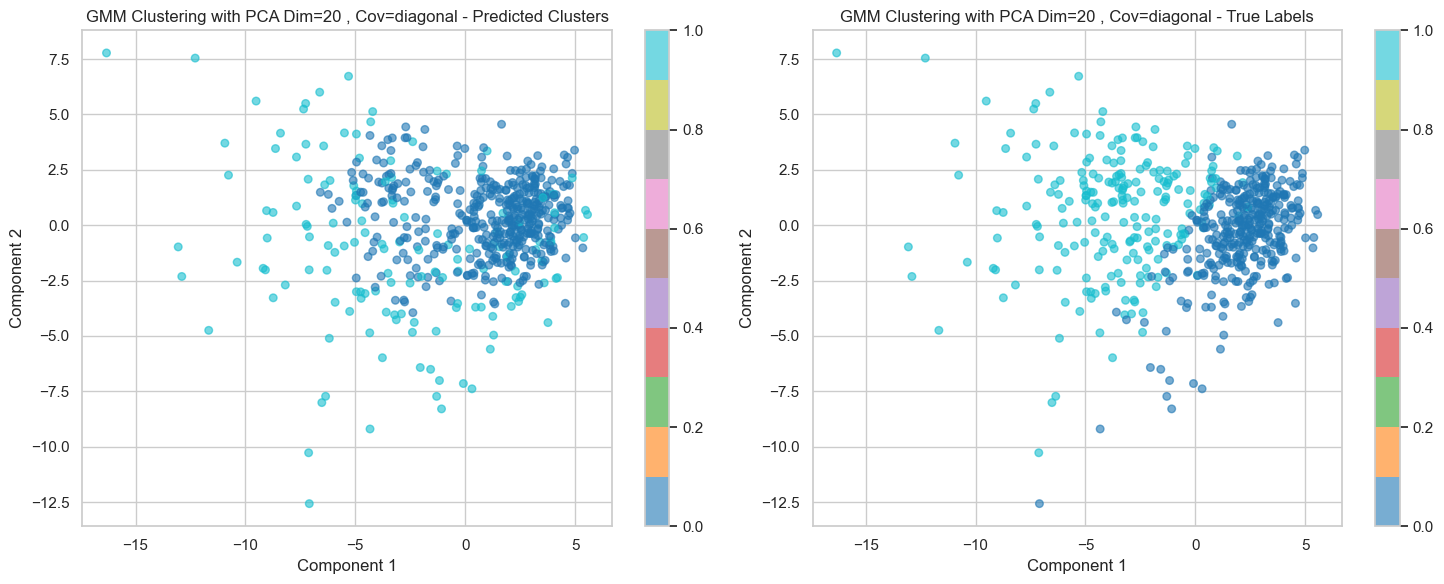


Confusion Matrix for PCA Dim=20, Covariance=diagonal:
[[297  60]
 [125  87]]
PCA Dim=20, Covariance=diagonal | Silhouette=0.2672, ARI=0.1077


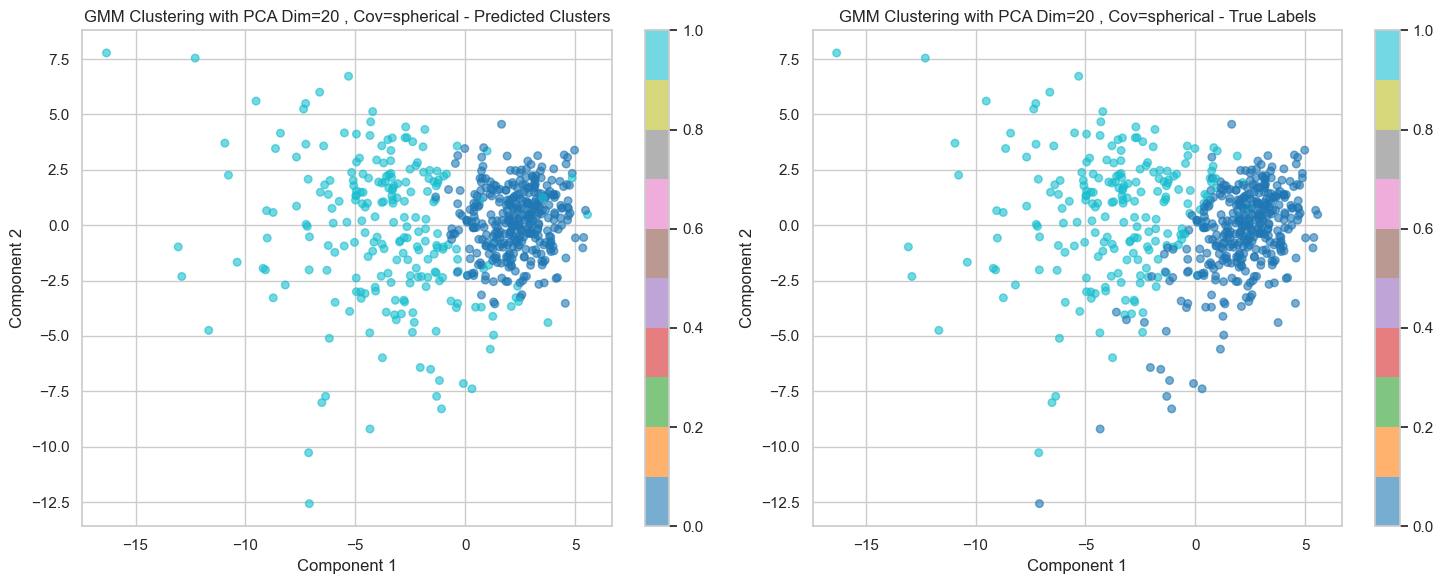


Confusion Matrix for PCA Dim=20, Covariance=spherical:
[[314  43]
 [ 31 181]]
PCA Dim=20, Covariance=spherical | Silhouette=0.3117, ARI=0.5454

Summary Table of Metrics Across PCA Dimensions and Covariance Types:
    PCA_Dim   Cov_Type  Silhouette  Davies-Bouldin  Calinski-Harabasz  \
0         2       full    0.487117        0.888999         529.640295   
1         2       tied    0.490136        0.897264         432.413013   
2         2   diagonal    0.485077        0.885979         532.380502   
3         2  spherical    0.474213        0.903968         507.218297   
4         5       full    0.329772        1.491987         209.244891   
5         5       tied    0.372356        1.406809          67.463597   
6         5   diagonal    0.341295        1.981556         111.948428   
7         5  spherical    0.372078        1.230479         306.147745   
8        10       full    0.277063        2.561111          57.948901   
9        10       tied    0.321334        1.859842      

In [119]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PCA 
# PCA dimensions to test
pca_dimensions = [2, 5, 10, 15, 20]

# Store results
all_results_exp4 = []
all_cm_exp4 = []

for dim in pca_dimensions:
    # Apply PCA
    pca = PCA.PCA(n_components=dim)  # Example: 5 components
    pca.fit(X)  
    X_red = pca.transform(X)    


    for cov_type in covariance_types_gmm:
        # Fit GMM
        gmm_model = fit_gmm(
            X_red,
            n_components=best_k_gmm,
            covariance_type=cov_type,
            max_iter=100,
            tol=1e-3,
            reg_covar=1e-6,
            random_state=42,
            verbose=False
        )
        labels_gmm_pca = predict(
            X_red,
            gmm_model['means'],
            gmm_model['covariances'],
            gmm_model['weights'],
            cov_type
        )
        eval.plot_2d_projection(X_red[:, :2], labels_gmm_pca, title=f'GMM Clustering with PCA Dim={dim} , Cov={cov_type}', true_labels=y)
        # Internal evaluation
        silhouette_gmm_pca, _ = eval.silhouette_score(X_red, labels_gmm_pca)
        db_gmm_pca = eval.davies_bouldin_index(X_red, labels_gmm_pca)
        ch_gmm_pca = eval.calinski_harabasz_index(X_red, labels_gmm_pca)
        wcss_gmm_pca = eval.within_cluster_sum_of_squares(X_red, labels_gmm_pca)

        # BIC/AIC
        bic_gmm_pca,aic_gmm_pca = compute_bic_aic(X_red, best_k_gmm, gmm_model['log_likelihood'], cov_type)
        # External evaluation
        ari_gmm_pca = eval.adjusted_rand_index(y, labels_gmm_pca)
        nmi_gmm_pca = eval.normalized_mutual_information(y, labels_gmm_pca)
        purity_gmm_pca = eval.purity_score(y, labels_gmm_pca)
        cm_gmm_pca, _, _ = eval.confusion_matrix(y, labels_gmm_pca)
        all_cm_exp4.append(cm_gmm_pca)

        cm_gmm_pca = unsupervised_confusion_matrix(y, labels_gmm_pca)
        print(f"\nConfusion Matrix for PCA Dim={dim}, Covariance={cov_type}:\n{cm_gmm_pca}")
        # Store results
        result = {
            "PCA_Dim": dim,
            "Cov_Type": cov_type,
            "Silhouette": silhouette_gmm_pca,
            "Davies-Bouldin": db_gmm_pca,
            "Calinski-Harabasz": ch_gmm_pca,
            "WCSS": wcss_gmm_pca,
            "BIC": bic_gmm_pca,
            "AIC": aic_gmm_pca,
            "ARI": ari_gmm_pca,
            "NMI": nmi_gmm_pca,
            "Purity": purity_gmm_pca
        }
        all_results_exp4.append(result)

        # Print progress
        print(f"PCA Dim={dim}, Covariance={cov_type} | Silhouette={silhouette_gmm_pca:.4f}, ARI={ari_gmm_pca:.4f}")
# Convert results to DataFrame
df_results_exp4 = pd.DataFrame(all_results_exp4)
print("\nSummary Table of Metrics Across PCA Dimensions and Covariance Types:")
print(df_results_exp4)

## **Experiment 5** = Autoencoder+K-Means

## code setup

Epoch 1/50, Loss: 0.020905, LR: 0.010000
Epoch 2/50, Loss: 0.020787, LR: 0.010000
Epoch 3/50, Loss: 0.020915, LR: 0.010000
Epoch 4/50, Loss: 0.020927, LR: 0.010000
Epoch 5/50, Loss: 0.020790, LR: 0.010000
Epoch 6/50, Loss: 0.020757, LR: 0.010000
Epoch 7/50, Loss: 0.020792, LR: 0.010000
Epoch 8/50, Loss: 0.020760, LR: 0.010000
Epoch 9/50, Loss: 0.020745, LR: 0.010000
Epoch 10/50, Loss: 0.020745, LR: 0.009500
Epoch 11/50, Loss: 0.020816, LR: 0.009500
Epoch 12/50, Loss: 0.020827, LR: 0.009500
Epoch 13/50, Loss: 0.020750, LR: 0.009500
Epoch 14/50, Loss: 0.020729, LR: 0.009500
Epoch 15/50, Loss: 0.020764, LR: 0.009500
Epoch 16/50, Loss: 0.020719, LR: 0.009500
Epoch 17/50, Loss: 0.020687, LR: 0.009500
Epoch 18/50, Loss: 0.020676, LR: 0.009500
Epoch 19/50, Loss: 0.020705, LR: 0.009500
Epoch 20/50, Loss: 0.020650, LR: 0.009025
Epoch 21/50, Loss: 0.020631, LR: 0.009025
Epoch 22/50, Loss: 0.020629, LR: 0.009025
Epoch 23/50, Loss: 0.020617, LR: 0.009025
Epoch 24/50, Loss: 0.020578, LR: 0.009025
E

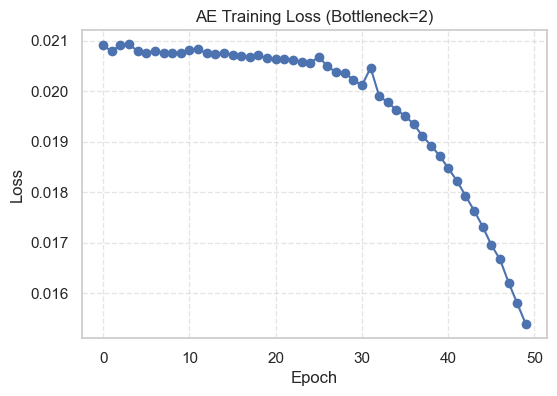

NameError: name 'X_Red' is not defined

In [120]:
from sklearn.datasets import load_breast_cancer
import Kmeans 
import Autoencoder
import numpy as np
import part3 as eval
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and scale data
data = load_breast_cancer()
X = data.data
y = data.target
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Define bottleneck sizes
bottleneck_sizes = [2, 5, 10, 15, 20]
k_values = [2, 3, 4, 5]
# Store results
all_results_exp5 = []
all_cm_exp5 = []

# Loop over bottleneck sizes
for size in bottleneck_sizes:
    layers_sizes = [X.shape[1], 64, size, 64, X.shape[1]]
    model_ae = Autoencoder.Autoencoder(
        layer_sizes=layers_sizes,
        activations=['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']
    )
    
    # Train AE
    loss_history_exp5 = model_ae.train(X)
    
    # Plot AE training loss curve
    plt.figure(figsize=(6,4))
    plt.plot(loss_history_exp5, marker='o')
    plt.title(f"AE Training Loss (Bottleneck={size})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
        # Compute elbow curve for this reduced data
    k_values_elbow_exp5, scores_wcss_exp5, optimal_k_exp5 = eval.compute_elbow_curve(X_Red, max_k=10, method='wcss')
    
    # Plot elbow curve
    plt.figure(figsize=(6,4))
    plt.plot(k_values_elbow_exp5, scores_wcss_exp5, marker='o')
    plt.axvline(optimal_k_exp5, color='r', linestyle='--', label=f"Optimal K={optimal_k_exp5}")
    plt.title(f"Elbow Curve (Bottleneck={size})")
    plt.xlabel("Number of clusters (K)")
    plt.ylabel("WCSS")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()
    
    # Encode
    X_Red = model_ae.encode(X)
    
    # Fit Kmeans
    for k in k_values:
        kmeans_model_exp5 = Kmeans.KMeans(k)
        kmeans_model_exp5.fit(X_Red)
    
    
    
    
        # Internal evaluation
        silhouette, _ = eval.silhouette_score(X_Red, kmeans_model_exp5.labels_)
        db = eval.davies_bouldin_index(X_Red, kmeans_model_exp5.labels_)
        ch = eval.calinski_harabasz_index(X_Red, kmeans_model_exp5.labels_)
        wcss = eval.within_cluster_sum_of_squares(X_Red, kmeans_model_exp5.labels_)
    
    
        # External evaluation
        ari = eval.adjusted_rand_index(y, kmeans_model_exp5.labels_)
        nmi = eval.normalized_mutual_information(y, kmeans_model_exp5.labels_)
        purity = eval.purity_score(y, kmeans_model_exp5.labels_)
        cm_exp5, true_classes, pred_clusters = eval.confusion_matrix(y, kmeans_model_exp5.labels_)
        
        # Autoencoder reconstruction
        X_recon = model_ae.reconstruct(X)
        mse, rmse = eval.reconstruction_error(X, X_recon)
    
        # Store results in dictionary
        result_exp5 = {
            "Bottleneck": size,
            "K": k,
            "Silhouette": silhouette,
            "Davies-Bouldin": db,
            "Calinski-Harabasz": ch,
            "WCSS": wcss,
            "ARI": ari,
            "NMI": nmi,
            "Purity": purity,
            "MSE": mse,
            "RMSE": rmse,
            
        }
        all_results_exp5.append(result_exp5)
        all_cm_exp5.append(cm_exp5)
        # Print metrics
        print("=" * 50)
        print(f"Bottleneck size: {size}")
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Davies-Bouldin Index: {db:.4f}")
        print(f"Calinski-Harabasz Index: {ch:.4f}")
        print(f"WCSS: {wcss:.4f}")
        print(f"ARI: {ari:.4f}")
        print(f"NMI: {nmi:.4f}")
        print(f"Purity: {purity:.4f}")
        print("Confusion Matrix:")
        print(cm_exp5)
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        
        # 2D projection visualization
        eval.plot_2d_projection(
            X_Red,
            kmeans_model_exp5.labels_,
            title=f"Autoencoder + Kmeans (Bottleneck={size}), (K={k})",
            true_labels=y
        )


# Convert results to DataFrame
df_results_exp5 = pd.DataFrame(all_results_exp5)
df_results_exp5.set_index(["Bottleneck", "K"], inplace=True)
print("\nSummary Table of Metrics Across Bottleneck Sizes and K values:")
print(df_results_exp5)
# Identify best bottleneck based on RMSE
best_bottleneck_rmse_exp5 = df_results_exp5["RMSE"].idxmin()
best_rmse_value_exp5 = df_results_exp5.loc[best_bottleneck_rmse_exp5, "RMSE"]

print("="*60)
print(f"Best bottleneck based on lowest RMSE: {best_bottleneck_rmse_exp5}")
print(f"Corresponding RMSE: {best_rmse_value_exp5:.6f}")
print("="*60)
# Heatmap of metrics
plt.figure(figsize=(12,6))
sns.heatmap(df_results_exp5, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Comparison of Metrics Across Bottleneck Sizes")
plt.show()
plt.figure(figsize=(8,6))
plt.scatter(df_results_exp5['RMSE'], df_results_exp5['Silhouette'], c=df_results_exp5.index.get_level_values('Bottleneck'), cmap='viridis', s=100)
plt.colorbar(label='Bottleneck size')
plt.xlabel("Reconstruction RMSE")
plt.ylabel("Silhouette Score")
plt.title("Reconstruction Error vs Clustering Performance (Silhouette)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
#Best covariance based on best Bottleneck and K
best_silhoute_exp5 = df_results_exp5["Silhouette"].idxmax()
cm_best_exp5 = all_cm_exp5[df_results_exp5.index.get_loc(best_silhoute_exp5)]
plt.figure(figsize=(6,5))
sns.heatmap(cm_best_exp5, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Clusters")
plt.ylabel("True Classes")
plt.title(f"Confusion Matrix (Bottleneck={best_bottleneck_rmse_exp5[0]}, K={best_silhoute_exp5[1]})")
plt.show()



## **Experiment 6** Autoencoder + GMM


## code Setup
 

Epoch 1/50, Loss: 0.020872, LR: 0.010000
Epoch 2/50, Loss: 0.020771, LR: 0.010000
Epoch 3/50, Loss: 0.020743, LR: 0.010000
Epoch 4/50, Loss: 0.020740, LR: 0.010000
Epoch 5/50, Loss: 0.020717, LR: 0.010000
Epoch 6/50, Loss: 0.020733, LR: 0.010000
Epoch 7/50, Loss: 0.020636, LR: 0.010000
Epoch 8/50, Loss: 0.020670, LR: 0.010000
Epoch 9/50, Loss: 0.020545, LR: 0.010000
Epoch 10/50, Loss: 0.020538, LR: 0.009500
Epoch 11/50, Loss: 0.020433, LR: 0.009500
Epoch 12/50, Loss: 0.020324, LR: 0.009500
Epoch 13/50, Loss: 0.020125, LR: 0.009500
Epoch 14/50, Loss: 0.020045, LR: 0.009500
Epoch 15/50, Loss: 0.019857, LR: 0.009500
Epoch 16/50, Loss: 0.019714, LR: 0.009500
Epoch 17/50, Loss: 0.019596, LR: 0.009500
Epoch 18/50, Loss: 0.019385, LR: 0.009500
Epoch 19/50, Loss: 0.019041, LR: 0.009500
Epoch 20/50, Loss: 0.018779, LR: 0.009025
Epoch 21/50, Loss: 0.018503, LR: 0.009025
Epoch 22/50, Loss: 0.018237, LR: 0.009025
Epoch 23/50, Loss: 0.017750, LR: 0.009025
Epoch 24/50, Loss: 0.017340, LR: 0.009025
E

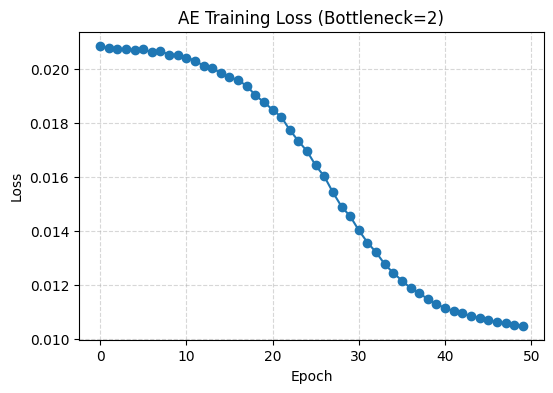

Bottleneck size: 2
Silhouette Score: 0.6388
Davies-Bouldin Index: 0.4706
Calinski-Harabasz Index: 1777.6999
WCSS: 11.8870
BIC: -2833.8649
AIC: -2881.6476
ARI: 0.6331
NMI: 0.5694
Purity: 0.8981
Confusion Matrix:
[[  5 207]
 [304  53]]
MSE: 0.010503
RMSE: 0.102482


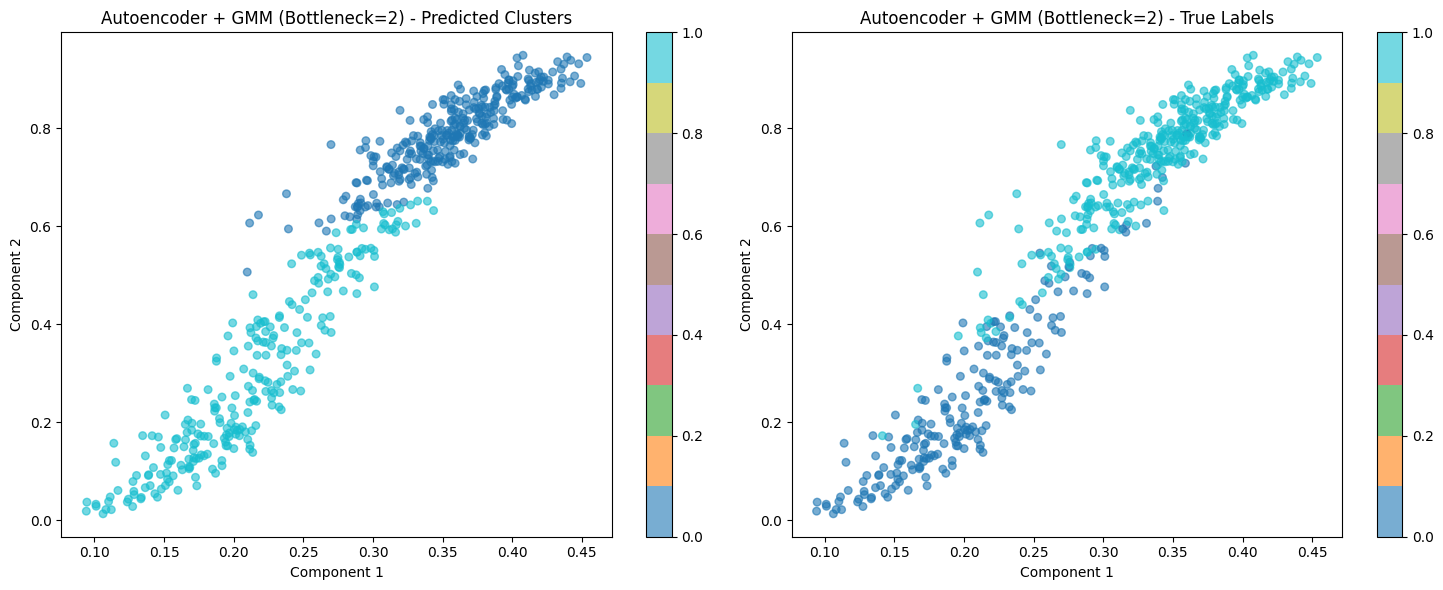

Epoch 1/50, Loss: 0.020939, LR: 0.010000
Epoch 2/50, Loss: 0.020808, LR: 0.010000
Epoch 3/50, Loss: 0.020788, LR: 0.010000
Epoch 4/50, Loss: 0.020796, LR: 0.010000
Epoch 5/50, Loss: 0.020736, LR: 0.010000
Epoch 6/50, Loss: 0.020729, LR: 0.010000
Epoch 7/50, Loss: 0.020713, LR: 0.010000
Epoch 8/50, Loss: 0.020761, LR: 0.010000
Epoch 9/50, Loss: 0.020717, LR: 0.010000
Epoch 10/50, Loss: 0.020683, LR: 0.009500
Epoch 11/50, Loss: 0.020683, LR: 0.009500
Epoch 12/50, Loss: 0.020671, LR: 0.009500
Epoch 13/50, Loss: 0.020670, LR: 0.009500
Epoch 14/50, Loss: 0.020669, LR: 0.009500
Epoch 15/50, Loss: 0.020660, LR: 0.009500
Epoch 16/50, Loss: 0.020565, LR: 0.009500
Epoch 17/50, Loss: 0.020540, LR: 0.009500
Epoch 18/50, Loss: 0.020491, LR: 0.009500
Epoch 19/50, Loss: 0.020517, LR: 0.009500
Epoch 20/50, Loss: 0.020508, LR: 0.009025
Epoch 21/50, Loss: 0.020390, LR: 0.009025
Epoch 22/50, Loss: 0.020351, LR: 0.009025
Epoch 23/50, Loss: 0.020263, LR: 0.009025
Epoch 24/50, Loss: 0.020223, LR: 0.009025
E

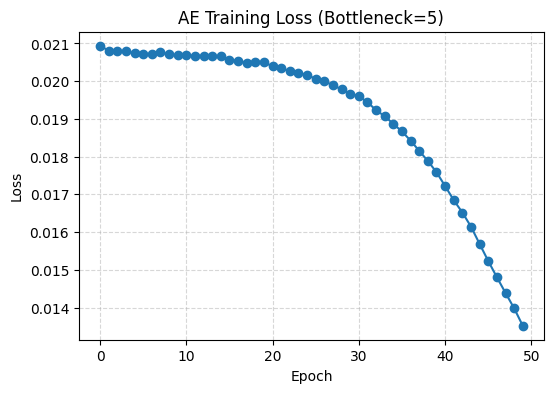

Bottleneck size: 5
Silhouette Score: 0.1149
Davies-Bouldin Index: 7.7653
Calinski-Harabasz Index: 6.4164
WCSS: 46.7364
BIC: -15272.4929
AIC: -15450.5920
ARI: -0.0136
NMI: 0.0201
Purity: 0.6274
Confusion Matrix:
[[ 40 172]
 [119 238]]
MSE: 0.013520
RMSE: 0.116275


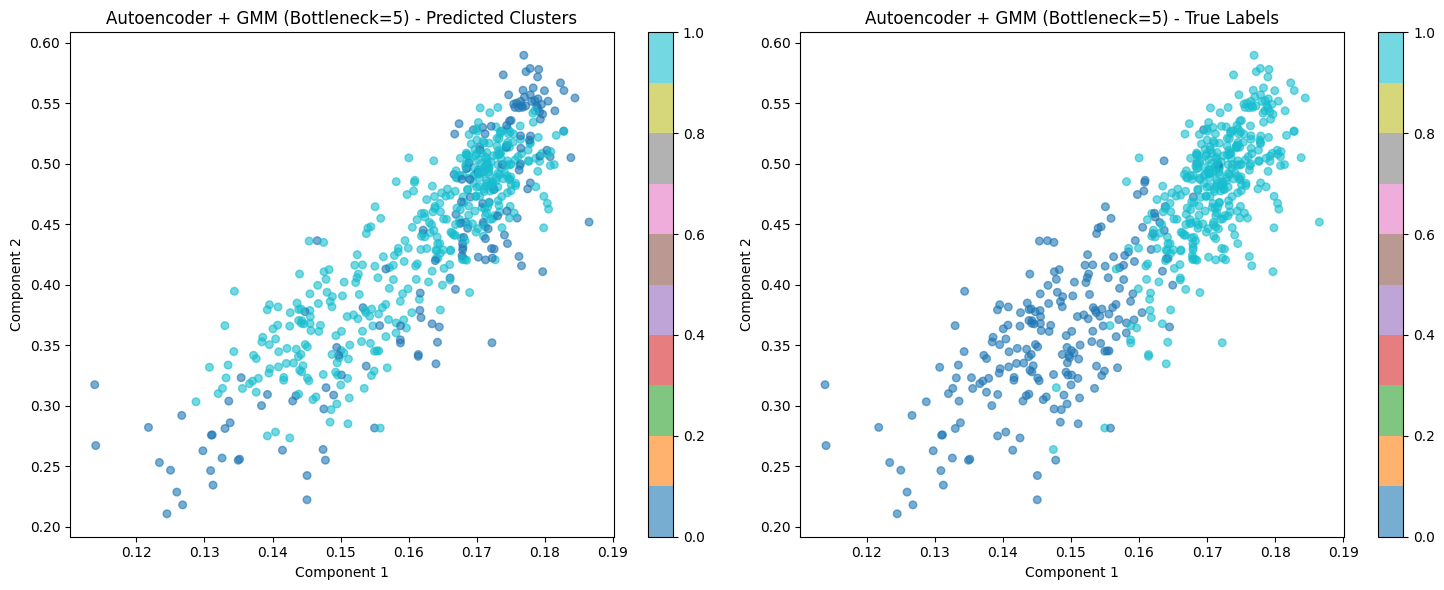

Epoch 1/50, Loss: 0.020936, LR: 0.010000
Epoch 2/50, Loss: 0.020818, LR: 0.010000
Epoch 3/50, Loss: 0.020765, LR: 0.010000
Epoch 4/50, Loss: 0.020751, LR: 0.010000
Epoch 5/50, Loss: 0.020765, LR: 0.010000
Epoch 6/50, Loss: 0.020786, LR: 0.010000
Epoch 7/50, Loss: 0.020910, LR: 0.010000
Epoch 8/50, Loss: 0.020782, LR: 0.010000
Epoch 9/50, Loss: 0.020710, LR: 0.010000
Epoch 10/50, Loss: 0.020750, LR: 0.009500
Epoch 11/50, Loss: 0.020843, LR: 0.009500
Epoch 12/50, Loss: 0.020671, LR: 0.009500
Epoch 13/50, Loss: 0.020670, LR: 0.009500
Epoch 14/50, Loss: 0.020657, LR: 0.009500
Epoch 15/50, Loss: 0.020593, LR: 0.009500
Epoch 16/50, Loss: 0.020583, LR: 0.009500
Epoch 17/50, Loss: 0.020610, LR: 0.009500
Epoch 18/50, Loss: 0.020583, LR: 0.009500
Epoch 19/50, Loss: 0.020539, LR: 0.009500
Epoch 20/50, Loss: 0.020524, LR: 0.009025
Epoch 21/50, Loss: 0.020504, LR: 0.009025
Epoch 22/50, Loss: 0.020579, LR: 0.009025
Epoch 23/50, Loss: 0.020421, LR: 0.009025
Epoch 24/50, Loss: 0.020428, LR: 0.009025
E

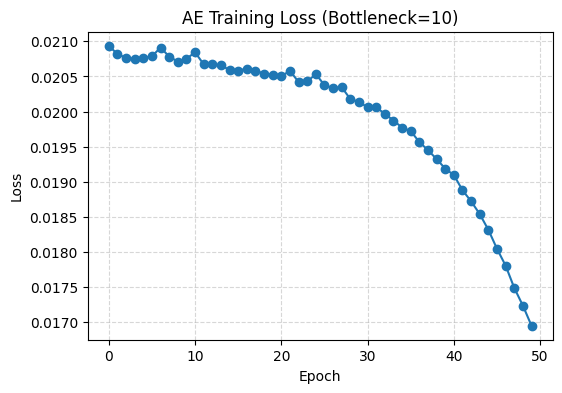

Bottleneck size: 10
Silhouette Score: 0.2322
Davies-Bouldin Index: 2.5315
Calinski-Harabasz Index: 34.3950
WCSS: 25.9733
BIC: -35481.2675
AIC: -36050.3158
ARI: 0.0301
NMI: 0.0106
Purity: 0.6309
Confusion Matrix:
[[ 33 179]
 [ 31 326]]
MSE: 0.016952
RMSE: 0.130202


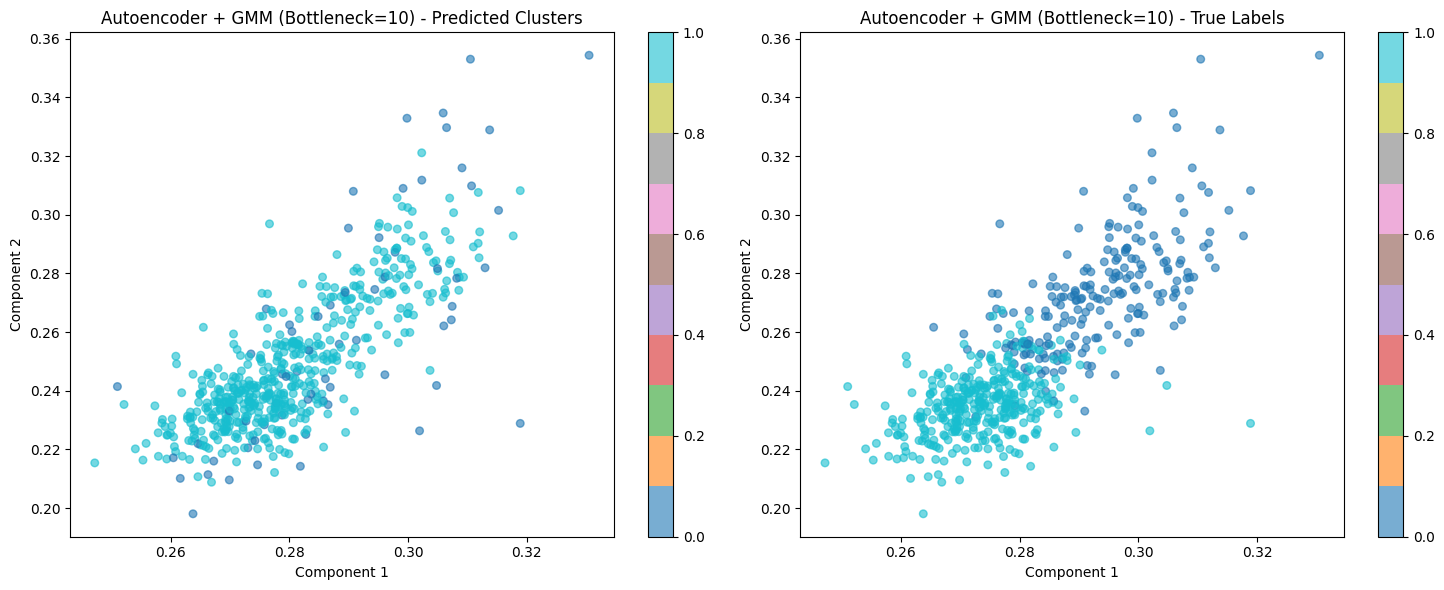

Epoch 1/50, Loss: 0.020898, LR: 0.010000
Epoch 2/50, Loss: 0.020894, LR: 0.010000
Epoch 3/50, Loss: 0.020767, LR: 0.010000
Epoch 4/50, Loss: 0.020887, LR: 0.010000
Epoch 5/50, Loss: 0.020778, LR: 0.010000
Epoch 6/50, Loss: 0.020778, LR: 0.010000
Epoch 7/50, Loss: 0.020744, LR: 0.010000
Epoch 8/50, Loss: 0.020775, LR: 0.010000
Epoch 9/50, Loss: 0.020722, LR: 0.010000
Epoch 10/50, Loss: 0.020711, LR: 0.009500
Epoch 11/50, Loss: 0.020698, LR: 0.009500
Epoch 12/50, Loss: 0.020678, LR: 0.009500
Epoch 13/50, Loss: 0.020707, LR: 0.009500
Epoch 14/50, Loss: 0.020704, LR: 0.009500
Epoch 15/50, Loss: 0.020643, LR: 0.009500
Epoch 16/50, Loss: 0.020628, LR: 0.009500
Epoch 17/50, Loss: 0.020644, LR: 0.009500
Epoch 18/50, Loss: 0.020662, LR: 0.009500
Epoch 19/50, Loss: 0.020587, LR: 0.009500
Epoch 20/50, Loss: 0.020659, LR: 0.009025
Epoch 21/50, Loss: 0.020578, LR: 0.009025
Epoch 22/50, Loss: 0.020550, LR: 0.009025
Epoch 23/50, Loss: 0.020564, LR: 0.009025
Epoch 24/50, Loss: 0.020518, LR: 0.009025
E

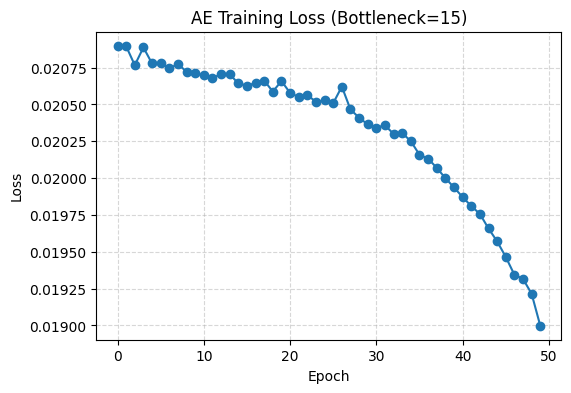

Bottleneck size: 15
Silhouette Score: 0.2304
Davies-Bouldin Index: 3.0592
Calinski-Harabasz Index: 23.4065
WCSS: 14.8019
BIC: -60618.9492
AIC: -61796.1408
ARI: 0.0294
NMI: 0.0104
Purity: 0.6309
Confusion Matrix:
[[ 32 180]
 [ 30 327]]
MSE: 0.018998
RMSE: 0.137834


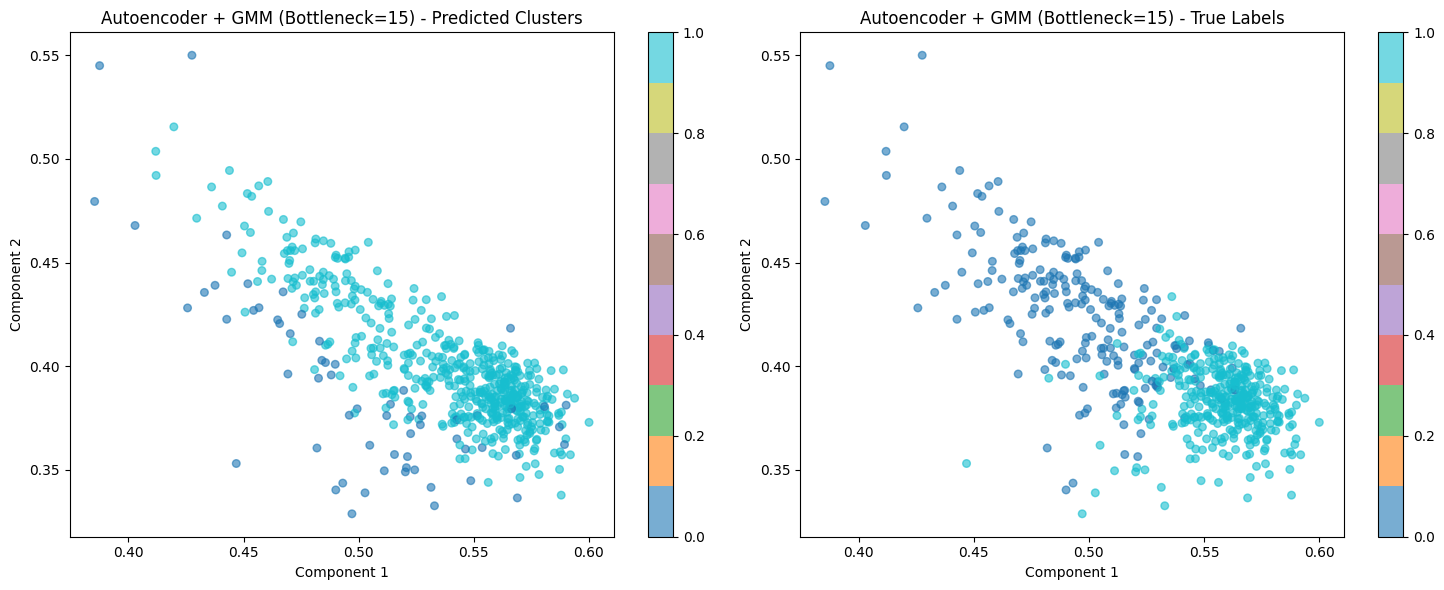

Epoch 1/50, Loss: 0.020898, LR: 0.010000
Epoch 2/50, Loss: 0.020944, LR: 0.010000
Epoch 3/50, Loss: 0.020793, LR: 0.010000
Epoch 4/50, Loss: 0.020739, LR: 0.010000
Epoch 5/50, Loss: 0.020723, LR: 0.010000
Epoch 6/50, Loss: 0.020730, LR: 0.010000
Epoch 7/50, Loss: 0.020711, LR: 0.010000
Epoch 8/50, Loss: 0.020756, LR: 0.010000
Epoch 9/50, Loss: 0.020705, LR: 0.010000
Epoch 10/50, Loss: 0.020732, LR: 0.009500
Epoch 11/50, Loss: 0.020673, LR: 0.009500
Epoch 12/50, Loss: 0.020637, LR: 0.009500
Epoch 13/50, Loss: 0.020612, LR: 0.009500
Epoch 14/50, Loss: 0.020623, LR: 0.009500
Epoch 15/50, Loss: 0.020600, LR: 0.009500
Epoch 16/50, Loss: 0.020572, LR: 0.009500
Epoch 17/50, Loss: 0.020607, LR: 0.009500
Epoch 18/50, Loss: 0.020561, LR: 0.009500
Epoch 19/50, Loss: 0.020545, LR: 0.009500
Epoch 20/50, Loss: 0.020522, LR: 0.009025
Epoch 21/50, Loss: 0.020535, LR: 0.009025
Epoch 22/50, Loss: 0.020500, LR: 0.009025
Epoch 23/50, Loss: 0.020499, LR: 0.009025
Epoch 24/50, Loss: 0.020486, LR: 0.009025
E

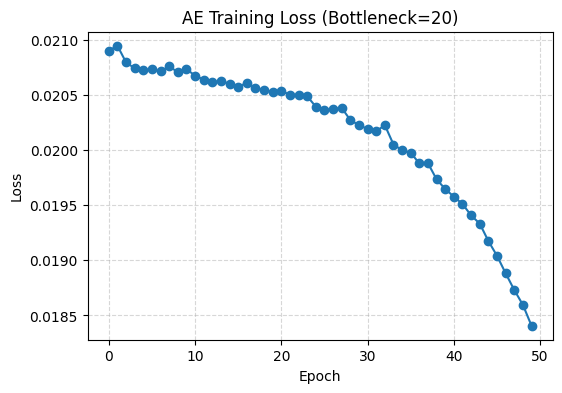

Bottleneck size: 20
Silhouette Score: 0.3493
Davies-Bouldin Index: 1.0504
Calinski-Harabasz Index: 141.3277
WCSS: 18.1605
BIC: -86585.7750
AIC: -88588.3039
ARI: 0.0794
NMI: 0.0616
Purity: 0.6731
Confusion Matrix:
[[173  39]
 [344  13]]
MSE: 0.018407
RMSE: 0.135673


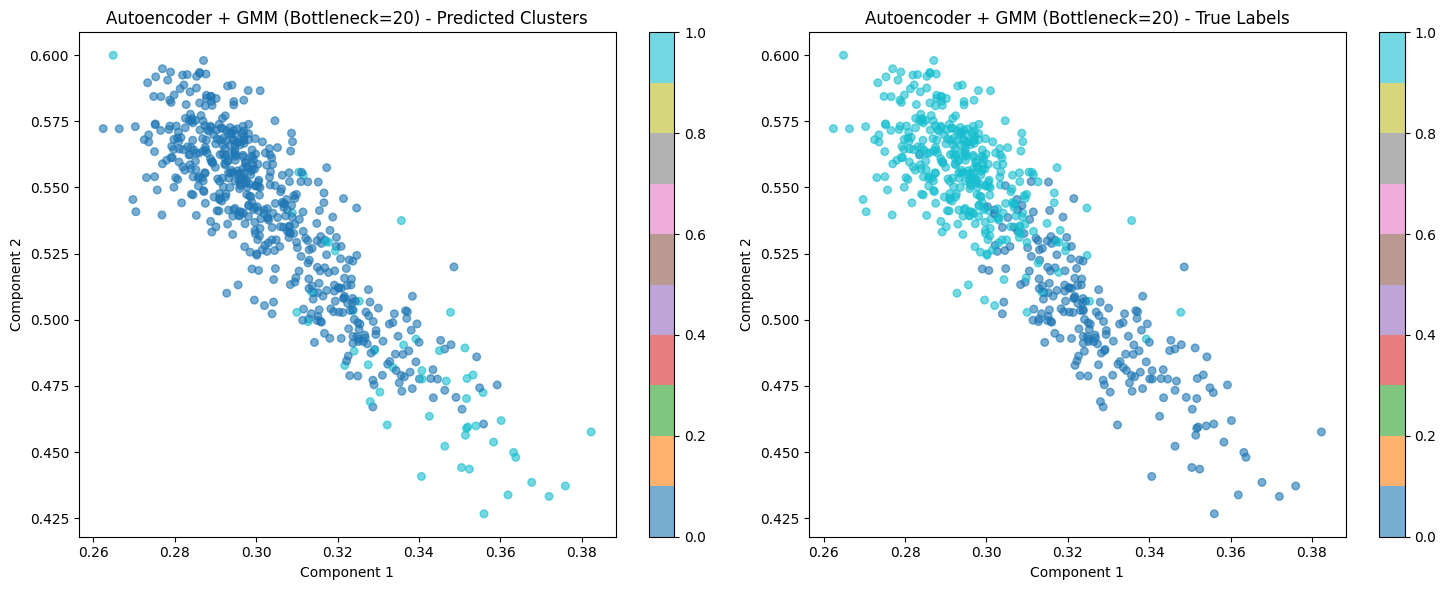


Summary Table of Metrics Across Bottleneck Sizes:
            Silhouette  Davies-Bouldin  Calinski-Harabasz       WCSS  \
Bottleneck                                                             
2             0.638838        0.470606        1777.699894  11.886977   
5             0.114922        7.765340           6.416380  46.736356   
10            0.232174        2.531496          34.394969  25.973310   
15            0.230380        3.059193          23.406481  14.801932   
20            0.349330        1.050433         141.327707  18.160478   

                     BIC           AIC       ARI       NMI    Purity  \
Bottleneck                                                             
2           -2833.864914  -2881.647599  0.633052  0.569427  0.898067   
5          -15272.492936 -15450.592034 -0.013631  0.020146  0.627417   
10         -35481.267452 -36050.315789  0.030100  0.010623  0.630931   
15         -60618.949166 -61796.140764  0.029400  0.010395  0.630931   
20         -

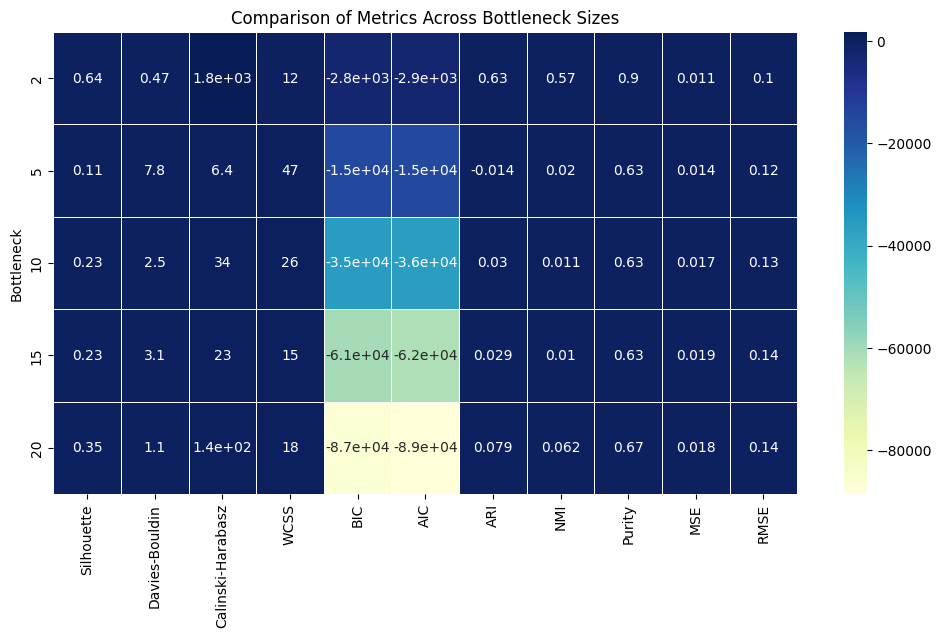

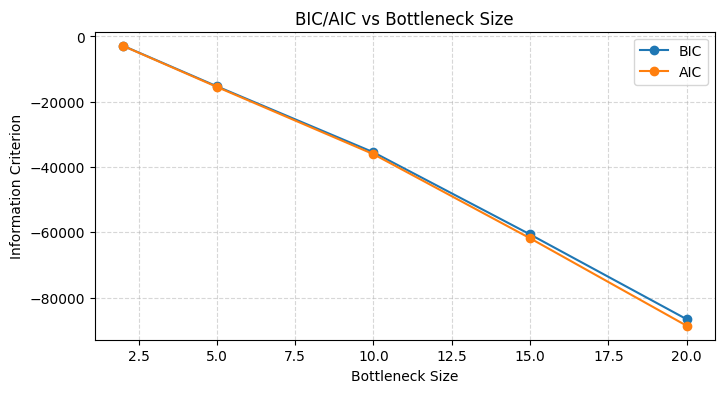

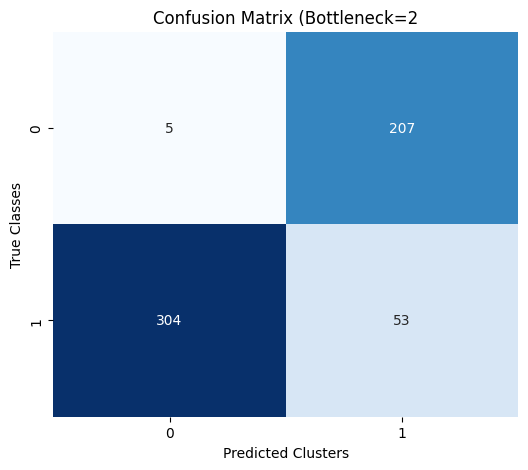

In [ ]:
from sklearn.datasets import load_breast_cancer
import gmm
import Autoencoder
import numpy as np
import part3 as eval
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and scale data
data = load_breast_cancer()
X = data.data
y = data.target
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Define bottleneck sizes
bottleneck_sizes = [2, 5, 10, 15, 20]

# Store results
all_results_exp6 = []
all_cm_exp6 = []

# Loop over bottleneck sizes
for size in bottleneck_sizes:
    layers_sizes = [X.shape[1], 64, size, 64, X.shape[1]]
    model_ae = Autoencoder.Autoencoder(
        layer_sizes=layers_sizes,
        activations=['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']
    )
    
    # Train AE
    loss_history_exp6 = model_ae.train(X)
    
    # Plot AE training loss curve
    plt.figure(figsize=(6,4))
    plt.plot(loss_history_exp6, marker='o')
    plt.title(f"AE Training Loss (Bottleneck={size})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    # Encode
    X_Red = model_ae.encode(X)
    
    # Fit GMM
    gmm_results_exp6 = gmm.fit_gmm(X_Red, n_components=2)
    labels_exp6 = gmm.predict(X_Red, gmm_results_exp6["means"], gmm_results_exp6["covariances"], gmm_results_exp6["weights"], 'full')
    
    # Internal evaluation
    silhouette, _ = eval.silhouette_score(X_Red, labels_exp6)
    db = eval.davies_bouldin_index(X_Red, labels_exp6)
    ch = eval.calinski_harabasz_index(X_Red, labels_exp6)
    wcss = eval.within_cluster_sum_of_squares(X_Red, labels_exp6)
    
    # BIC/AIC
    bic, aic = eval.compute_bic_aic(
        X_Red,
        n_components=2,
        log_likelihood=gmm_results_exp6["log_likelihood"],
        covariance_type="full"
    )
    
    # External evaluation
    ari = eval.adjusted_rand_index(y, labels_exp6)
    nmi = eval.normalized_mutual_information(y, labels_exp6)
    purity = eval.purity_score(y, labels_exp6)
    cm, true_classes, pred_clusters = eval.confusion_matrix(y, labels_exp6)
    all_cm_exp6.append(cm)
    # Autoencoder reconstruction
    X_recon = model_ae.reconstruct(X)
    mse, rmse = eval.reconstruction_error(X, X_recon)
    
    # Store results in dictionary
    result_exp6 = {
        "Bottleneck": size,
        "Silhouette": silhouette,
        "Davies-Bouldin": db,
        "Calinski-Harabasz": ch,
        "WCSS": wcss,
        "BIC": bic,
        "AIC": aic,
        "ARI": ari,
        "NMI": nmi,
        "Purity": purity,
        "MSE": mse,
        "RMSE": rmse
    }
    all_results_exp6.append(result_exp6)
    
    # Print metrics
    print("=" * 50)
    print(f"Bottleneck size: {size}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db:.4f}")
    print(f"Calinski-Harabasz Index: {ch:.4f}")
    print(f"WCSS: {wcss:.4f}")
    print(f"BIC: {bic:.4f}")
    print(f"AIC: {aic:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"NMI: {nmi:.4f}")
    print(f"Purity: {purity:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    
    # 2D projection visualization
    eval.plot_2d_projection(
        X_Red,
        labels_exp6,
        title=f"Autoencoder + GMM (Bottleneck={size})",
        true_labels=y
    )


# Convert results to DataFrame
df_results_exp6 = pd.DataFrame(all_results_exp6)
df_results_exp6.set_index("Bottleneck", inplace=True)
print("\nSummary Table of Metrics Across Bottleneck Sizes:")
print(df_results_exp6)
# Identify best bottleneck based on RMSE
best_bottleneck_rmse_exp6 = df_results_exp6["RMSE"].idxmin()
best_rmse_value_exp6 = df_results_exp6.loc[best_bottleneck_rmse_exp6, "RMSE"]

print("="*60)
print(f"Best bottleneck based on lowest RMSE: {best_bottleneck_rmse_exp6}")
print(f"Corresponding RMSE: {best_rmse_value_exp6:.6f}")
print("="*60)
# Heatmap of metrics
plt.figure(figsize=(12,6))
sns.heatmap(df_results_exp6, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Comparison of Metrics Across Bottleneck Sizes")
plt.show()

# Optional: BIC/AIC curves
plt.figure(figsize=(8,4))
plt.plot(df_results_exp6.index, df_results_exp6["BIC"], marker='o', label="BIC")
plt.plot(df_results_exp6.index, df_results_exp6["AIC"], marker='o', label="AIC")
plt.xlabel("Bottleneck Size")
plt.ylabel("Information Criterion")
plt.title("BIC/AIC vs Bottleneck Size")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
best_silhoute_exp6 = df_results_exp6["Silhouette"].idxmax()
cm_best_exp6 = all_cm_exp6[df_results_exp6.index.get_loc(best_silhoute_exp6)]
plt.figure(figsize=(6,5))
sns.heatmap(cm_best_exp6, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Clusters")
plt.ylabel("True Classes")
plt.title(f"Confusion Matrix (Bottleneck={best_bottleneck_rmse_exp6}")
plt.show()


## comparison with experiment 4:


## **Analyzing Space and Time complexity**

| Experiment                       | Task                            | Time Complexity | Space Complexity |
| -------------------------------- | ------------------------------- | --------------- | ---------------- |
| **1. K-Means on original data**  | Cluster original features       | n × k × t × d   | n × d + k × d    |
| **2. GMM on original data**      | Fit Gaussian Mixture Models     | n × k × t × d²  | n × d + k × d²   |
| **3. K-Means after PCA**         | Cluster reduced features        | n × k × t × p   | n × p + k × p    |
| **4. GMM after PCA**             | Fit GMM on PCA-reduced data     | n × k × t × p²  | n × p + k × p²   |
| **5. K-Means after Autoencoder** | Cluster encoded features        | n × k × t × b   | n × b + k × b    |
| **6. GMM after Autoencoder**     | Fit GMM on autoencoder features | n × k × t × b²  | n × b + k × b²   |


Symbols:

n = number of samples

d = original feature dimension

p = number of PCA components

b = bottleneck size of Autoencoder

k = number of clusters / GMM components

t = number of iterations until convergence

# comparison of cluster composition across different models

In [122]:
comparison_table = pd.DataFrame({
    "Experiment": [
        "K-Means (Original)",
        "GMM (Original)",
        "K-Means + PCA",
        "GMM + PCA",
        "K-Means + Autoencoder",
        "GMM + Autoencoder"
    ],
    "Silhouette": [best_sil_value_exp1, silhouette_gmm, best_sil_value_exp3, silhouette_gmm_pca, s5, s6],
    "Davies-Bouldin": [best_dbi_value_exp1, db_gmm, best_dbi_value_exp3, db_gmm_pca, db5, db6],
    "Calinski-Harabasz": [best_ch_value_exp1, ch_gmm, best_ch_value_exp3, ch_gmm_pca, ch5, ch6],
    "WCSS": [best_wcss_value_exp1, wcss_gmm, best_wcss_value_exp3, wcss_gmm_pca, w5, None],
    "ARI": [best_ari_value_exp1, ari_gmm, best_ari_value_exp3, ari_gmm_pca, ari5, ari6],
    "NMI": [best_nmi_value_exp1, nmi_gmm, best_nmi_value_exp3, nmi_gmm_pca, nmi5, nmi6],
    "Purity": [best_purity_value_exp1, purity_gmm, best_purity_value_exp3, purity_gmm_pca, p5, p6],
})

comparison_table.set_index("Experiment", inplace=True)
print(comparison_table)



NameError: name 's5' is not defined